In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import trompy as tp
import csv
from datetime import datetime, timedelta


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000


ctl_color= "gray"
exp_color="deepskyblue"
fig_folder=r"../plots\\"
READ_METAFILE= pd.read_excel(r"..\FEDXD_METAFILE.xls" ,sheet_name="METAFILE" )

#READ_METAFILE


[Link to Choice_1](#Choice_1)

[Link to Choice_2](#Choice_2)


In [3]:
metafile_path = "../FEDXD_METAFILE.xls"  # Adjusted path to the uploaded file
rows, header = tp.metafilereader(metafile_path, sheetname="METAFILE")

def get_FEDevents(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:  # Check if rows is empty
        print(f"No data in file {filename}.")
        return []

    # Assuming the first column contains the date and time info
    # and the "Event" column is consistent with the provided files
    event_column_index = 9  # Based on your CSV structure
    
    # Determine which date format should be used (assuming consistency, so just using one format)
    date_format = formats[0]

    timestamps = []
    for row in rows:
        if row[event_column_index] == eventname:
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if not timestamps:  # If no events match, return an empty list
        return []

    # Calculate time since "lights on", using the first event as reference if needed
    t0 = timestamps[0].strftime(date_format)
    day = t0.split()[0]
    lightson = day + " 07:00:00"  # Assuming lights on at 7 AM
    refpoint = datetime.strptime(lightson, date_format)

    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes
# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Iterate through the rows to process and group data
for row in rows:
    mouse_id = row[0]
    sex = row[1]  # Assuming this is the correct column for SEX
    diet = row[7]  # Assuming this is the correct column for DIET
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"


    # Create a unique key for each group
    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect timestamps for this row's file and pellet event
    timestamps = get_FEDevents(filename, "Pellet")
    pellet_count = len(timestamps)
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count
    })

# cell below takes "number of pellets per hour" and stores them separately hour by hour

In [4]:


def get_FEDevents_hourly(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:
        print(f"No data in file {filename}.")
        return []

    event_column_index = 9
    date_format = formats[0]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[event_column_index] == eventname]
    
    if not timestamps:
        return []

    # Sort timestamps to ensure chronological order
    timestamps.sort()

    # Calculate hourly counts, ignoring the first and last hour
    first_event_time = timestamps[0]
    last_event_time = timestamps[-1]
    current_time = first_event_time + timedelta(hours=1)  # Start from the second hour
    end_time = last_event_time  # Include events up to the last hour

    hourly_counts = []
    while current_time < end_time:
        next_hour = current_time + timedelta(hours=1)
        count = sum(1 for t in timestamps if current_time <= t < next_hour)
        hourly_counts.append(count)
        current_time = next_hour

    # Remove the count for the last hour, as we need to ignore it
    if hourly_counts:
        hourly_counts = hourly_counts[:-1]

    return hourly_counts

# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Assuming you've already read the metadata into `rows`
for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect hourly pellet counts for this row's file and pellet event
    hourly_counts = get_FEDevents_hourly(filename, "Pellet")
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "HOURLY_COUNTS": hourly_counts
    })


In [5]:
# Flatten the grouped_lists into a list of dictionaries
data_to_convert = []
for group_key, records in grouped_lists.items():
    for record in records:
        # Decompose the group_key back into its components if needed
        sex, diet, choice_session, pellet_type = group_key.split("_")
        # Create a new dictionary for each record that includes the group information
        record_data = {
            "MOUSEID": record["MOUSEID"],
            "SEX": record["SEX"],
            "DIET": record["DIET"],
            "CHOICE_SESSION": record["CHOICE_SESSION"],
            "PELLET_TYPE": record["PELLET_TYPE"],
            "HOURLY_COUNTS": record["HOURLY_COUNTS"]
        }
        # Append the new dictionary to the list
        data_to_convert.append(record_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_to_convert)




if not df.empty and "HOURLY_COUNTS" in df.columns and df["HOURLY_COUNTS"].apply(len).max() > 0:
    max_length = df["HOURLY_COUNTS"].apply(len).max()
    hourly_counts_df = pd.DataFrame(df["HOURLY_COUNTS"].tolist(), index=df.index,
                                    columns=[f"Hour_{i+1}" for i in range(max_length)])
    df_hourly_pellet = pd.concat([df.drop(columns=["HOURLY_COUNTS"]), hourly_counts_df], axis=1)

# Show the DataFrame structure (optional)
print(df_hourly_pellet.head())

   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  Hour_1  Hour_2  Hour_3  \
0  FEDXDF1   F   PR             0.0         MIX     7.0     0.0    22.0   
1  FEDXDF1   F   PR             0.0         MIX     0.0     0.0     2.0   
2  FEDXDF2   F   PR             0.0         MIX    30.0     3.0     0.0   
3  FEDXDF2   F   PR             0.0         MIX     2.0     2.0     0.0   
4  FEDXDF3   F   PR             0.0         MIX    23.0     9.0     1.0   

   Hour_4  Hour_5  Hour_6  Hour_7  Hour_8  Hour_9  Hour_10  Hour_11  Hour_12  \
0     0.0     0.0     9.0    10.0    10.0     9.0      8.0     10.0     17.0   
1     2.0     0.0     0.0     3.0     0.0    10.0      4.0      9.0      5.0   
2     3.0     2.0     4.0     5.0     6.0    10.0     23.0     14.0     22.0   
3     0.0     0.0     1.0     0.0     1.0     1.0      5.0     15.0     11.0   
4    21.0     2.0     4.0    17.0     0.0    10.0     16.0     15.0     22.0   

   Hour_13  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Ho

In [9]:
df_hourly_pellet
df_hourly_pellet.to_csv('../results/HOURLY_PELLET.csv', index=False)

# cells below measures components of a meal such as size, frequency and number FROM TWO FEDs in choices

In [7]:
def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    path = os.path.join("../data", filename)  # Ensure path is correctly specified
    timestamps = []
    with open(path) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]
    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return [], None
    
    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]
    return pellettimes, refpoint

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=1):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, [0]*24)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    current_event = [pellettimes[0]]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) >= min_pellets_for_meal:
                meals.append(current_event)
            else:
                snacks.append(current_event)
            current_event = [pellettimes[i + 1]]

    if current_event:
        if len(current_event) >= min_pellets_for_meal:
            meals.append(current_event)
        else:
            snacks.append(current_event)

    nmeals = len(meals)
    nsnacks = len(snacks)
    hourly_meals = np.zeros(24)
    for meal in meals:
        start_hour = int(meal[0]) % 24
        hourly_meals[start_hour] += 1

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else total_pellets / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals.tolist()

# Assuming 'rows' contains your metafile data
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    # Use a common group key for sessions 1, 2, 3, 4, regardless of pellet type
    if choice_session in [1, 2, 3, 4]:
        group_key = f"{mouse_id}_{sex}_{diet}_{choice_session}"
    else:
        group_key = f"{mouse_id}_{sex}_{diet}_{choice_session}_{pellet_type}"

    if group_key not in grouped_lists:
        grouped_lists[group_key] = []

    grouped_lists[group_key].append(filename)

# Combine pellet times and calculate metrics
final_data = []

for group_key, filenames in grouped_lists.items():
    all_pellet_times = []
    for filename in filenames:
        pellettimes, refpoint = get_FEDevents(filename, "Pellet")
        all_pellet_times.extend(pellettimes)

    if not all_pellet_times:
        continue

    all_pellet_times.sort()
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals = get_meal_and_snack_metrics(all_pellet_times)

    entry = {
        "GROUP_KEY": group_key,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
        "HOURLY_MEALS": hourly_meals,
        "TOTAL_PELLETS": len(all_pellet_times)
    }
    final_data.append(entry)
# Add hourly meals data
    for hour in range(24):
        entry[f"MEALS_HOUR_{hour}"] = hourly_meals[hour]

    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append(entry)
df = pd.DataFrame(final_data)


# Split GROUP_KEY into separate columns
df[['MOUSE ID', 'SEX', 'DIET', 'CHOICE_SESSION', "PELLET_TYPE"]] = df['GROUP_KEY'].str.split('_', expand=True)
# Convert to DataFrame
df = df[~df['GROUP_KEY'].str.contains('MIX')]
df


# Convert to DataFrame
df = df[~df['GROUP_KEY'].str.contains('MIX')]
# df = df.drop(columns=['HOURLY_MEALS'])
df = df.drop(columns=["SNACK_FREQUENCY"])
df = df.drop(columns=["SNACK_SIZE"])
df = df.drop(columns=["NUMBER_OF_SNACKS"])
cols = df.columns[-5:].tolist() + df.columns[:-5].tolist()
df = df[cols]
df

#df.to_csv(r'../results/MULTI_FED_MEAL_HOURLY.csv', index = False)


,MOUSE ID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,GROUP_KEY,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY,HOURLY_MEALS,TOTAL_PELLETS,MEALS_HOUR_0,MEALS_HOUR_1,MEALS_HOUR_2,MEALS_HOUR_3,MEALS_HOUR_4,MEALS_HOUR_5,MEALS_HOUR_6,MEALS_HOUR_7,MEALS_HOUR_8,MEALS_HOUR_9,MEALS_HOUR_10,MEALS_HOUR_11,MEALS_HOUR_12,MEALS_HOUR_13,MEALS_HOUR_14,MEALS_HOUR_15,MEALS_HOUR_16,MEALS_HOUR_17,MEALS_HOUR_18,MEALS_HOUR_19,MEALS_HOUR_20,MEALS_HOUR_21,MEALS_HOUR_22,MEALS_HOUR_23
1,FEDXDF1,F,PR,1.0,None,FEDXDF1_F_PR_1.0,1.609091,110,4.912115,"[7.0, 0.0, 4.0, 10.0, 13.0, 0.0, 0.0, 7.0, 0.0...",177,7.0,0.0,4.0,10.0,13.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,5.0,5.0,4.0,6.0,7.0,9.0,9.0,6.0,9.0,6.0,0.0,0.0
2,FEDXDF1,F,PR,2.0,None,FEDXDF1_F_PR_2.0,1.528000,125,5.610413,"[7.0, 1.0, 0.0, 11.0, 14.0, 2.0, 0.0, 0.0, 3.0...",191,7.0,1.0,0.0,11.0,14.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,5.0,9.0,8.0,9.0,9.0,11.0,9.0,9.0,3.0,0.0,0.0,9.0
3,FEDXDF1,F,PR,3.0,None,FEDXDF1_F_PR_3.0,1.313253,166,7.324158,"[9.0, 0.0, 4.0, 1.0, 9.0, 17.0, 8.0, 2.0, 0.0,...",218,9.0,0.0,4.0,1.0,9.0,17.0,8.0,2.0,0.0,4.0,1.0,6.0,11.0,14.0,11.0,13.0,11.0,12.0,12.0,10.0,4.0,0.0,0.0,7.0
4,FEDXDF1,F,PR,4.0,None,FEDXDF1_F_PR_4.0,1.087912,91,3.984238,"[0.0, 0.0, 0.0, 2.0, 3.0, 7.0, 4.0, 0.0, 0.0, ...",99,0.0,0.0,0.0,2.0,3.0,7.0,4.0,0.0,0.0,0.0,4.0,1.0,8.0,7.0,7.0,7.0,6.0,5.0,6.0,7.0,4.0,4.0,5.0,4.0
6,FEDXDF2,F,PR,1.0,None,FEDXDF2_F_PR_1.0,1.733333,90,3.763809,"[3.0, 0.0, 7.0, 9.0, 4.0, 2.0, 0.0, 1.0, 2.0, ...",156,3.0,0.0,7.0,9.0,4.0,2.0,0.0,1.0,2.0,5.0,0.0,3.0,8.0,5.0,5.0,5.0,4.0,6.0,6.0,4.0,5.0,6.0,0.0,0.0
7,FEDXDF2,F,PR,2.0,None,FEDXDF2_F_PR_2.0,1.403509,114,5.194476,"[8.0, 1.0, 0.0, 6.0, 8.0, 3.0, 0.0, 0.0, 5.0, ...",160,8.0,1.0,0.0,6.0,8.0,3.0,0.0,0.0,5.0,1.0,1.0,7.0,1.0,11.0,8.0,8.0,4.0,4.0,13.0,8.0,9.0,2.0,0.0,6.0
8,FEDXDF2,F,PR,3.0,None,FEDXDF2_F_PR_3.0,1.353448,116,5.166526,"[5.0, 1.0, 9.0, 0.0, 4.0, 8.0, 2.0, 0.0, 2.0, ...",157,5.0,1.0,9.0,0.0,4.0,8.0,2.0,0.0,2.0,3.0,3.0,4.0,5.0,12.0,9.0,3.0,11.0,11.0,9.0,9.0,0.0,0.0,6.0,0.0
9,FEDXDF2,F,PR,4.0,None,FEDXDF2_F_PR_4.0,1.059829,117,5.112519,"[5.0, 5.0, 4.0, 5.0, 2.0, 7.0, 1.0, 0.0, 2.0, ...",124,5.0,5.0,4.0,5.0,2.0,7.0,1.0,0.0,2.0,2.0,5.0,7.0,7.0,11.0,8.0,7.0,5.0,6.0,6.0,5.0,4.0,4.0,5.0,4.0
11,FEDXDF3,F,PR,1.0,None,FEDXDF3_F_PR_1.0,1.574803,127,5.292953,"[3.0, 9.0, 9.0, 6.0, 7.0, 11.0, 0.0, 0.0, 4.0,...",200,3.0,9.0,9.0,6.0,7.0,11.0,0.0,0.0,4.0,0.0,1.0,5.0,8.0,8.0,7.0,5.0,8.0,9.0,7.0,8.0,6.0,5.0,1.0,0.0
12,FEDXDF3,F,PR,2.0,None,FEDXDF3_F_PR_2.0,1.743119,109,4.802702,"[1.0, 6.0, 0.0, 6.0, 10.0, 4.0, 0.0, 0.0, 5.0,...",190,1.0,6.0,0.0,6.0,10.0,4.0,0.0,0.0,5.0,0.0,2.0,3.0,6.0,8.0,9.0,10.0,5.0,3.0,2.0,7.0,6.0,6.0,7.0,3.0


<a id="Choice_1"></a>
## Choice_1

In [15]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = df[(df['SEX'] == 'M') & (df['CHOICE_SESSION'] == 1) & (df['DIET'] == 'NR')]
av_mealnumber= male_nr_pellet_C1.groupby(['MOUSE ID', 'DIET'])['NUMBER_OF_MEALS'].mean().unstack()
av_mealnumber
# female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
# average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


# male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
# average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


# female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
# average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()

# cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
# cas5_mpr1= average_pellets_per_type_mpr1['CAS5']
# cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
# cas5_fpr1= average_pellets_per_type_fpr1['CAS5']

# cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
# cas5_mnr1= average_pellets_per_type_mnr1['CAS5']
# cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
# cas5_fnr1= average_pellets_per_type_fnr1['CAS5']

# group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
# group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
# group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
# group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# # Plotting using barscatter


# ctl_color_rgb = (0.8, 0.8, 0.8)
# exp_color_rgb = (0.1,0.7,0.7)

# f, ax = plt.subplots(figsize=(12,6))
# _, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
#                                  ax=ax, paired=True, linewidth=1, groupwidth=0.90,
#                                  barfacecolor_option="individual",
#                                  baredgecolor=["white"]*8,
#                                  barfacecolor=["deepskyblue", "purple", "deepskyblue", "purple", "deepskyblue", "black", "deepskyblue", "black"],
#                                  barlabels=["CAS20 Males PR", "CAS5 Males PR",  "CAS20 Males NR", "CAS5 Males NR"])




NameError: name 'data' is not defined

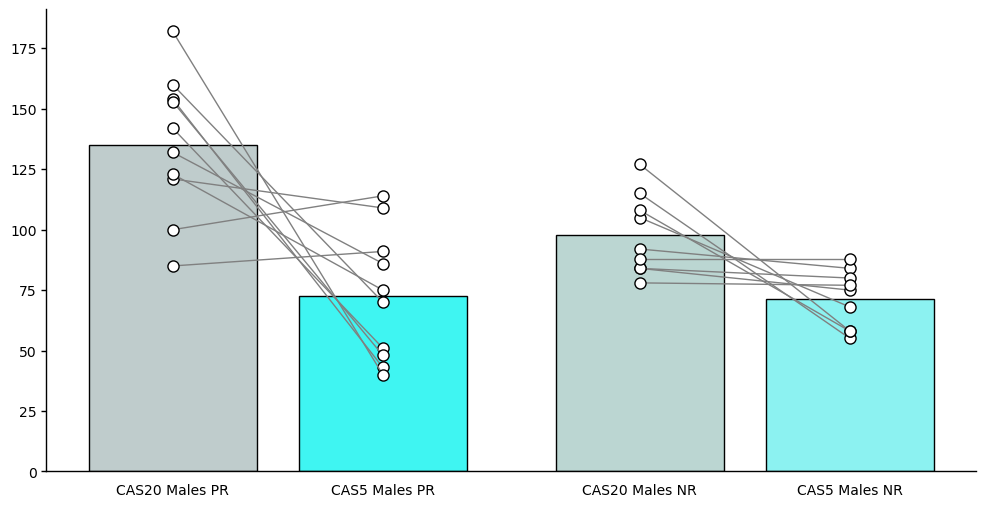

In [41]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['CAS5']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['CAS5']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['CAS5']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['CAS5']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "CAS5 Males PR",  "CAS20 Males NR", "CAS5 Males NR"])




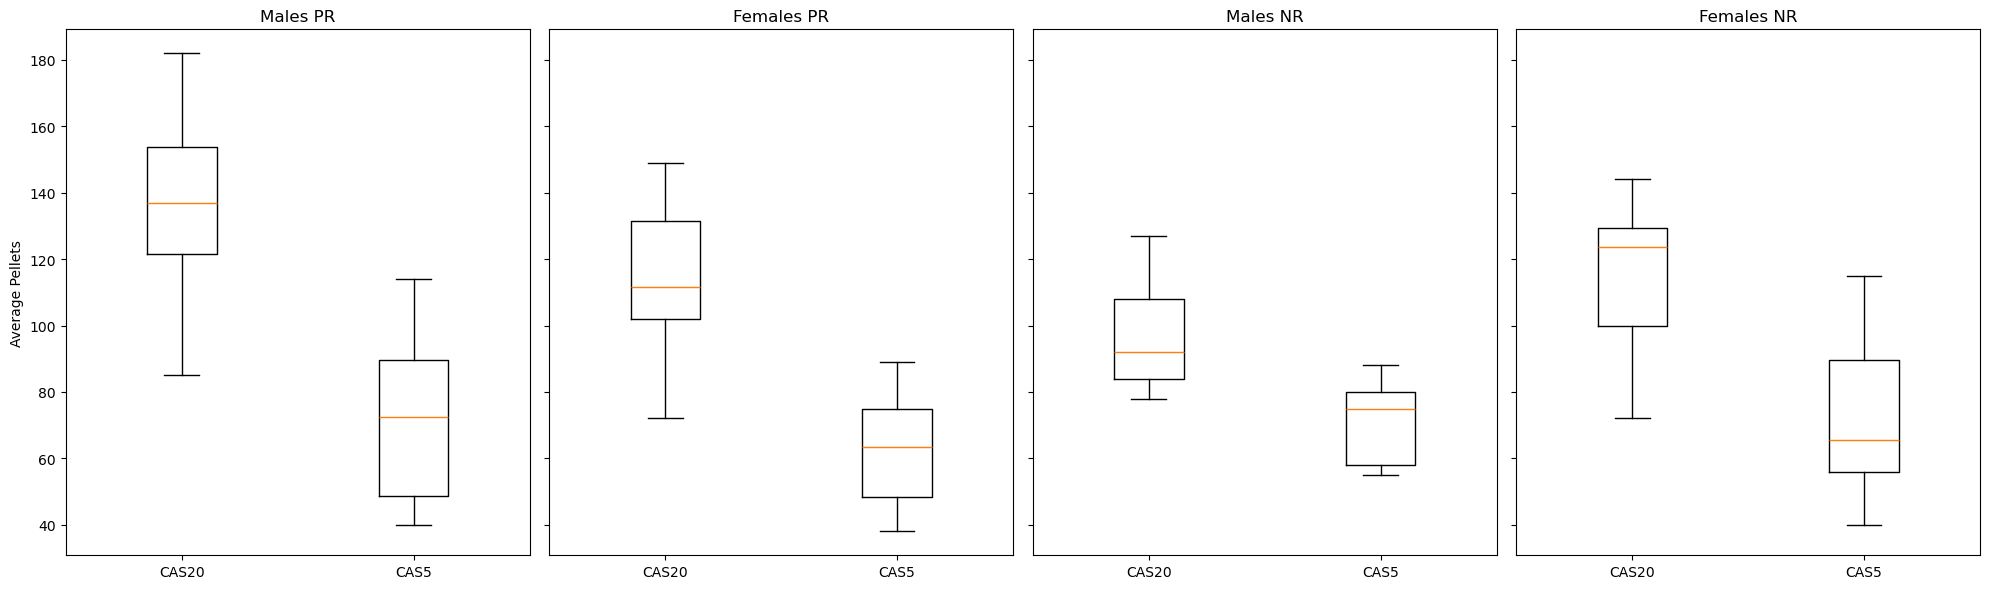

In [42]:
import matplotlib.pyplot as plt

# Creating figure and axis objects
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)

# Titles for subplots
titles = ['Males PR', 'Females PR', 'Males NR', 'Females NR']

# Grouping the data for each subplot
grouped_data = [group_data_male_pr, group_data_female_pr, group_data_male_nr, group_data_female_nr]

# Colors for each box in the boxplot
colors = ['red', 'black']

# Generating boxplots for each group
for ax, group, title in zip(axes, grouped_data, titles):
    ax.boxplot(group, patch_artist=False, notch=False, widths=0.3)
    # Coloring each box
    for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)
    # Setting labels and titles
    ax.set_title(title)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['CAS20', 'CAS5'])
    if ax is axes[0]:
        ax.set_ylabel('Average Pellets')

plt.tight_layout()
plt.show()


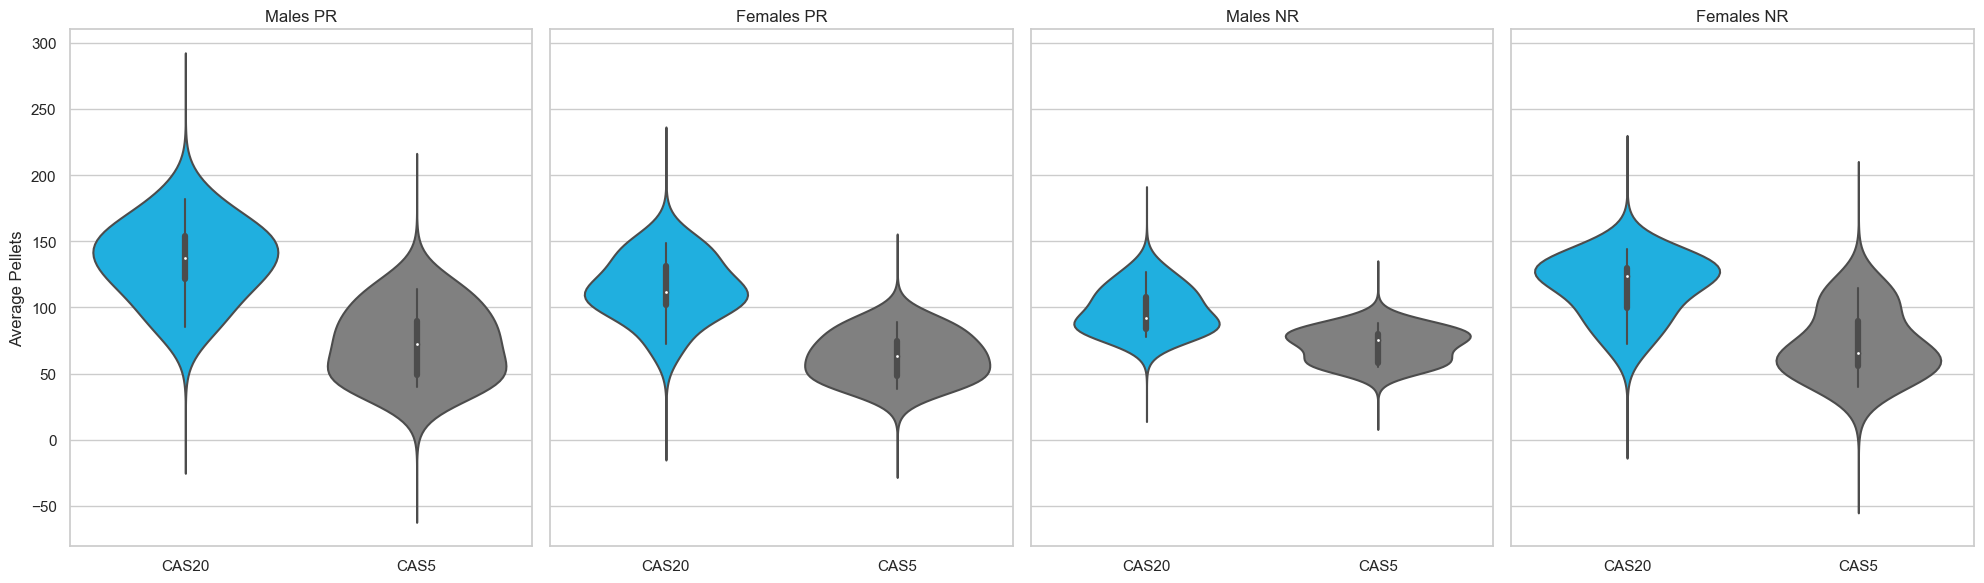

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Creating figure and axis objects
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)

# Titles for subplots
titles = ['Males PR', 'Females PR', 'Males NR', 'Females NR']

# Grouping the data for each subplot
grouped_data = [group_data_male_pr, group_data_female_pr, group_data_male_nr, group_data_female_nr]

# Colors for each violin in the plot
palette = ["deepskyblue", "grey"]

# Generating violin plots for each group
for ax, group, title in zip(axes, grouped_data, titles):
    sns.violinplot(data=group, ax=ax, cut=6, palette=palette)
    # Setting labels and titles
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['CAS20', 'CAS5'])
    if ax is axes[0]:
        ax.set_ylabel('Average Pellets')

plt.tight_layout()
plt.show()


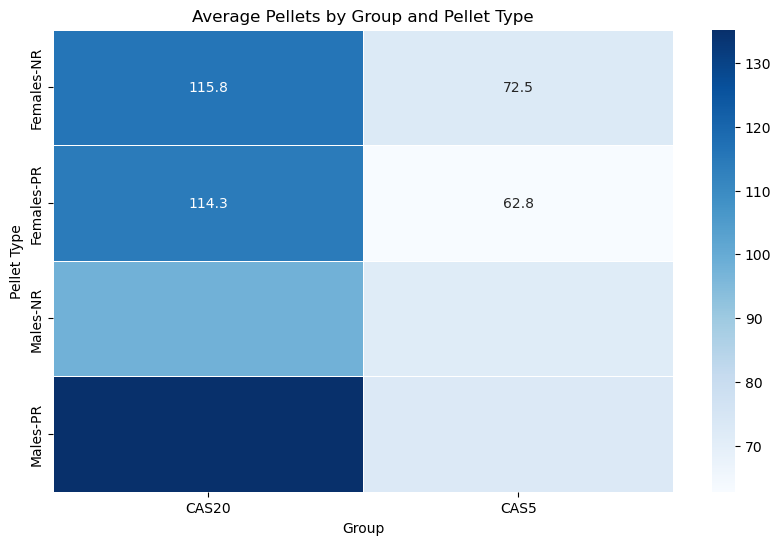

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with each column correctly labeled for group and pellet type
data_dict = {
    "Males PR CAS20": cas20_mpr1,
    "Males PR CAS5": cas5_mpr1,
    "Females PR CAS20": cas20_fpr1,
    "Females PR CAS5": cas5_fpr1,
    "Males NR CAS20": cas20_mnr1,
    "Males NR CAS5": cas5_mnr1,
    "Females NR CAS20": cas20_fnr1,
    "Females NR CAS5": cas5_fnr1
}

# Concatenate all series into a single DataFrame, ensuring all series are the same length
full_data = pd.concat(data_dict, axis=1)

# Calculate mean across each column
mean_values = full_data.mean()

# Convert the Series of mean values into a DataFrame
mean_df = pd.DataFrame(mean_values, columns=['Average Pellets'])

# Split the index to create a MultiIndex for unstacking
mean_df.index = pd.MultiIndex.from_tuples([tuple(idx.split()) for idx in mean_df.index])

# Unstack the DataFrame to create a 2D DataFrame for the heatmap
heatmap_df = mean_df.unstack(level=-1)['Average Pellets']

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap="Blues", fmt=".1f", linewidths=.5)
plt.title('Average Pellets by Group and Pellet Type')
plt.ylabel('Pellet Type')
plt.xlabel('Group')
plt.show()


# <font color  = "cyan"> MEAL COMPONENT <font />

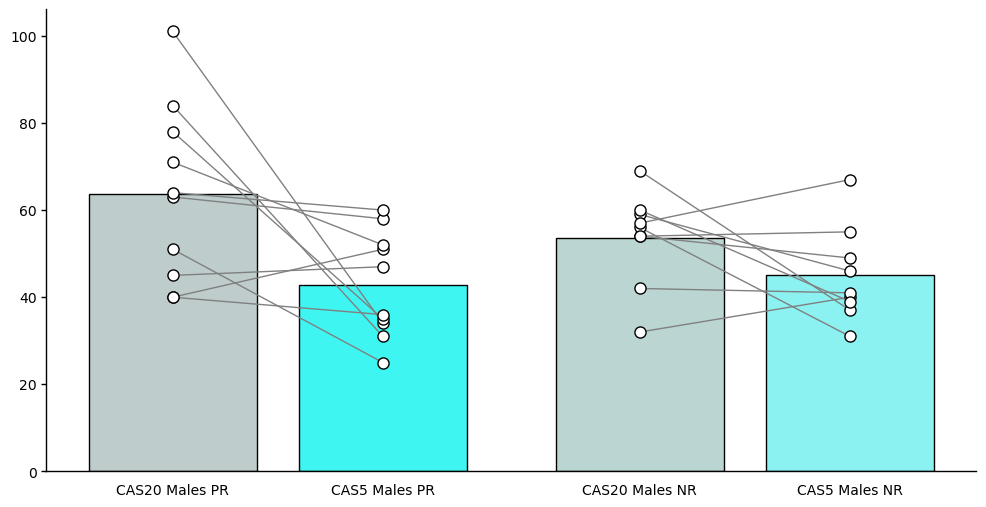

In [23]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['CAS5']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['CAS5']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['CAS5']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['CAS5']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "CAS5 Males PR",  "CAS20 Males NR", "CAS5 Males NR"])




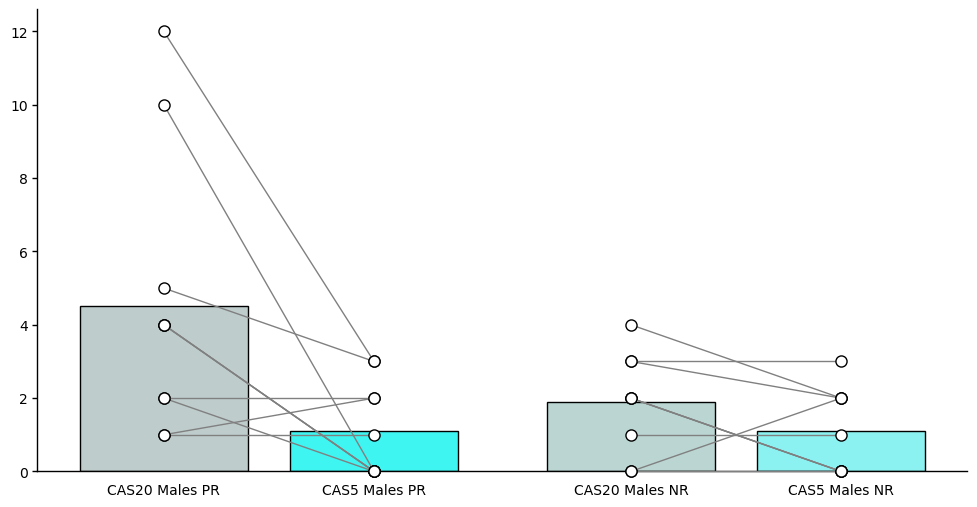

In [24]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['CAS5']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['CAS5']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['CAS5']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['CAS5']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "CAS5 Males PR",  "CAS20 Males NR", "CAS5 Males NR"])




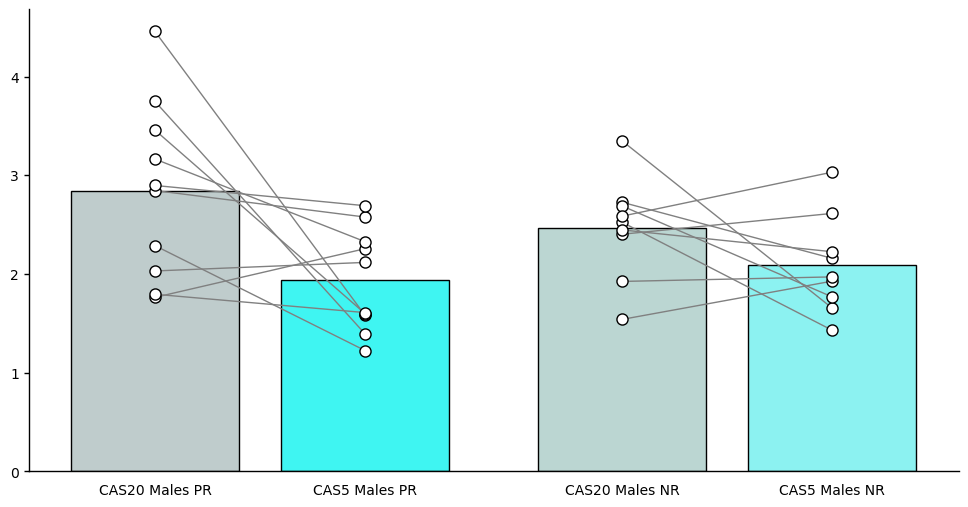

In [25]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['SNACK_FREQUENCY'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['SNACK_FREQUENCY'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['SNACK_FREQUENCY'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['SNACK_FREQUENCY'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['CAS5']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['CAS5']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['CAS5']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['CAS5']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "CAS5 Males PR",  "CAS20 Males NR", "CAS5 Males NR"])




# CHOICE SESSION 2 CAS20 vs SUC

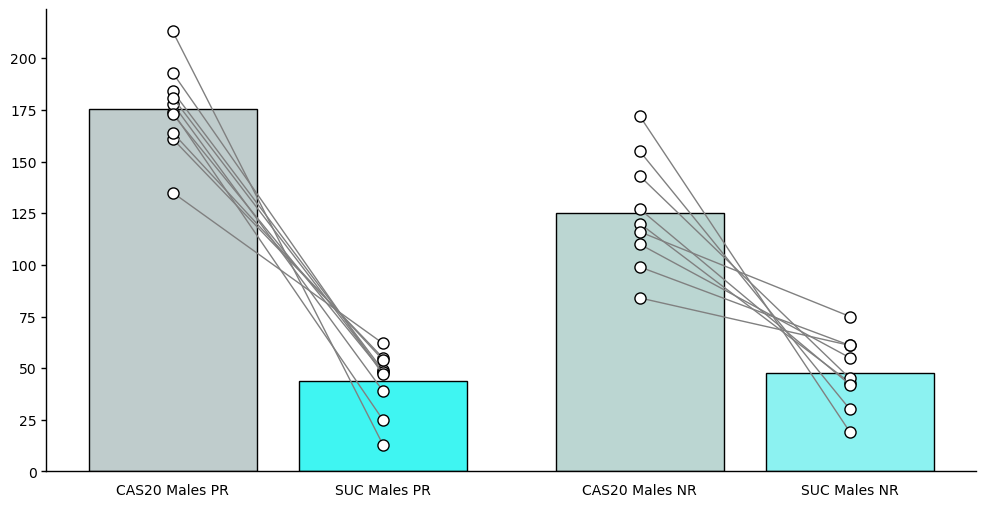

In [33]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['COUNT'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['SUC']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['SUC']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['SUC']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['SUC']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "SUC Males PR",  "CAS20 Males NR", "SUC Males NR"])




<a id="Choice_2"></a>
## Choice_2

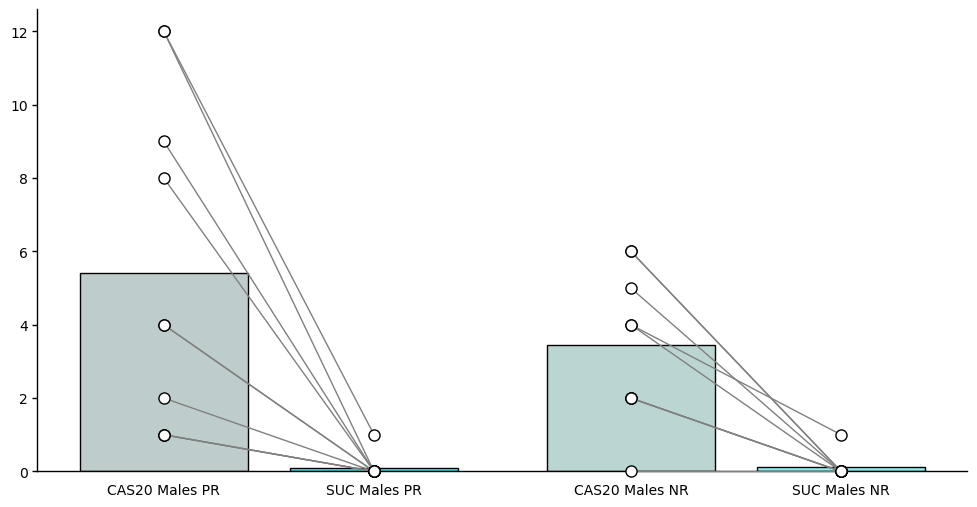

In [38]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_MEALS'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['SUC']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['SUC']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['SUC']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['SUC']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "SUC Males PR",  "CAS20 Males NR", "SUC Males NR"])




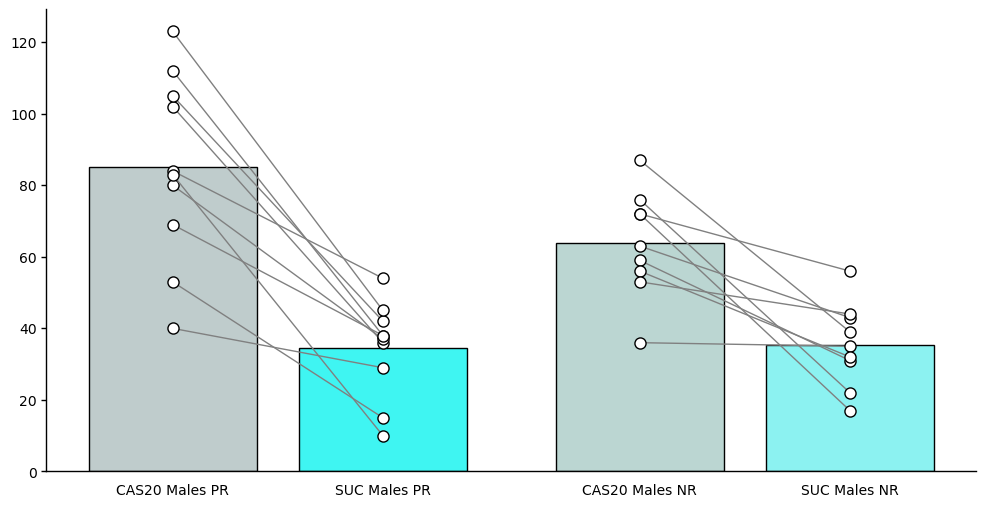

In [36]:
# Filter the data for male PR mice in choice session 1
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_mnr1= male_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()

female_nr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]
average_pellets_per_type_fnr1= female_nr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()


male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_mpr1= male_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()


female_pr_pellet_C1 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]
average_pellets_per_type_fpr1= female_pr_pellet_C1.groupby(['MOUSEID', 'PELLET_TYPE'])['NUMBER_OF_SNACKS'].mean().unstack()

cas20_mpr1= average_pellets_per_type_mpr1['CAS20']
cas5_mpr1= average_pellets_per_type_mpr1['SUC']
cas20_fpr1= average_pellets_per_type_fpr1['CAS20']
cas5_fpr1= average_pellets_per_type_fpr1['SUC']

cas20_mnr1= average_pellets_per_type_mnr1['CAS20']
cas5_mnr1= average_pellets_per_type_mnr1['SUC']
cas20_fnr1= average_pellets_per_type_fnr1['CAS20']
cas5_fnr1= average_pellets_per_type_fnr1['SUC']

group_data_male_pr = [cas20_mpr1.tolist(), cas5_mpr1.tolist()]
group_data_female_pr = [cas20_fpr1.tolist(), cas5_fpr1.tolist()]
group_data_male_nr = [cas20_mnr1.tolist(), cas5_mnr1.tolist()]
group_data_female_nr = [cas20_fnr1.tolist(), cas5_fnr1.tolist()]

# Plotting using barscatter

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([group_data_male_pr, group_data_male_nr],
                                 ax=ax, paired=True, linewidth=1, groupwidth=0.90,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20 Males PR", "SUC Males PR",  "CAS20 Males NR", "SUC Males NR"])




# CHOICE SESSION 3 CAS5 vs SUC

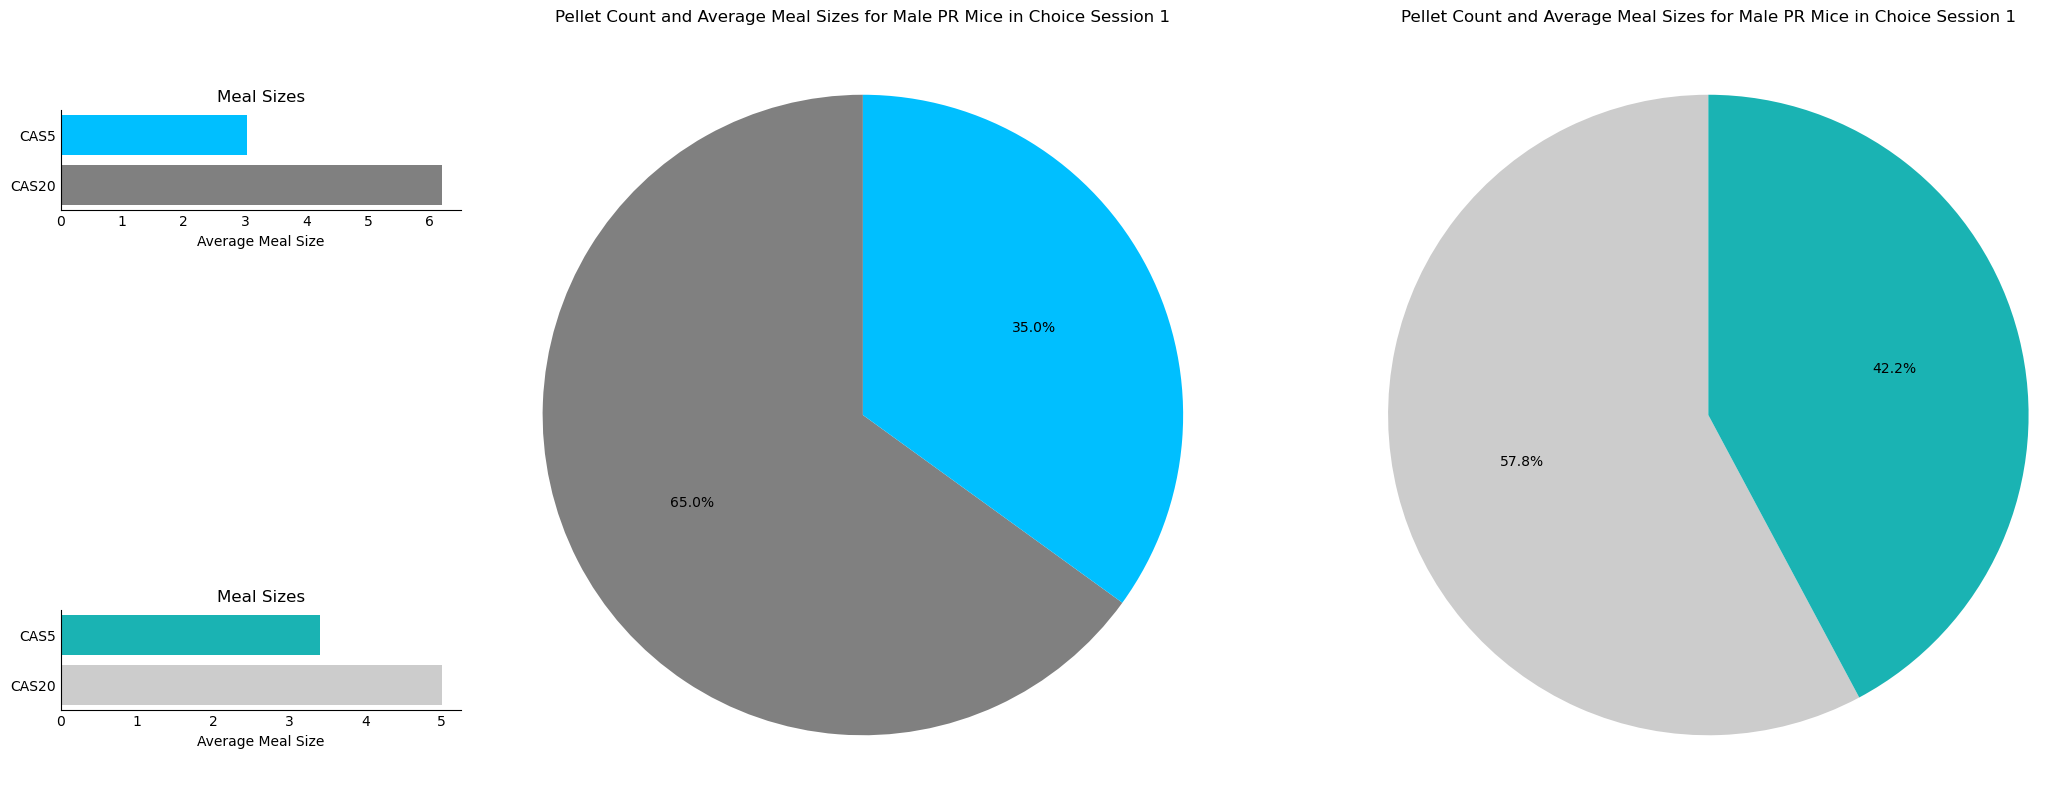

In [52]:

# Filter the data for male PR mice in choice session 1 for pellet counts
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()
# Filter the data for male NR  mice in choice session 1 for pellet counts
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
total_pellet_counts_male_nr = male_nr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()

# Filter the same data for meal sizes
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Filter the same data for meal size control animals
male_nr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
average_meal_size_male_nr = male_nr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()



fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ctl_color_rgb = (0.8, 0.8, 0.8)
exp_color_rgb = (0.1,0.7,0.7)

axs[0].pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1)
axs[0].set_title('Pellet Count and Average Meal Sizes for Male PR Mice in Choice Session 1')
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create an inset axis for the barh plot
# The parameters are [left, bottom, width, height] in figure coordinates (0 to 1)
inset_axes = fig.add_axes([-0.1, 0.7, 0.2, 0.1]) # Adjust the width and height as needed to make the barh plot smaller
inset_axes.barh(average_meal_sizes_male_pr.index, average_meal_sizes_male_pr, color=[ctl_color, exp_color])
inset_axes.set_xlabel('Average Meal Size')
inset_axes.set_title('Meal Sizes')

inset_axes.spines['top'].set_visible(False)
inset_axes.spines['right'].set_visible(False)
inset_axes.spines['left'].set_visible(True)
inset_axes.spines['bottom'].set_visible(True)
inset_axes.tick_params(axis='both', which='both', length=0)



axs[1].pie(total_pellet_counts_male_nr, autopct='%1.1f%%', startangle=90, colors=[ctl_color_rgb, exp_color_rgb], radius=1)
axs[1].set_title('Pellet Count and Average Meal Sizes for Male PR Mice in Choice Session 1')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create an inset axis for the barh plot
# The parameters are [left, bottom, width, height] in figure coordinates (0 to 1)
inset_axes = fig.add_axes([-0.1, 0.2, 0.2, 0.1]) # Adjust the width and height as needed to make the barh plot smaller
inset_axes.barh(average_meal_size_male_nr.index, average_meal_size_male_nr, color=[ctl_color_rgb, exp_color_rgb])
inset_axes.set_xlabel('Average Meal Size')
inset_axes.set_title('Meal Sizes')

inset_axes.spines['top'].set_visible(False)
inset_axes.spines['right'].set_visible(False)
inset_axes.spines['left'].set_visible(True)
inset_axes.spines['bottom'].set_visible(True)
inset_axes.tick_params(axis='both', which='both', length=0)

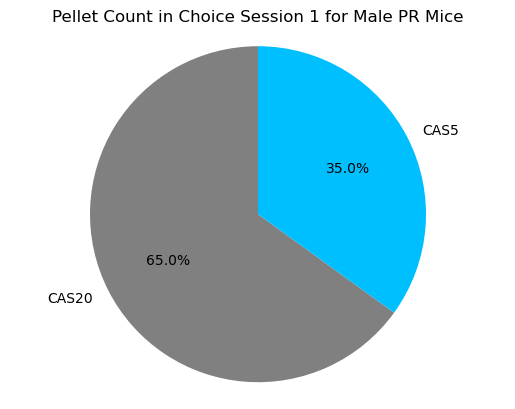

In [70]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()

# Create a pie plot
plt.pie(total_pellet_counts_male_pr, labels=total_pellet_counts_male_pr.index, autopct='%1.1f%%', startangle=90,colors=[ctl_color, exp_color])
plt.title('Pellet Count in Choice Session 1 for Male PR Mice')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

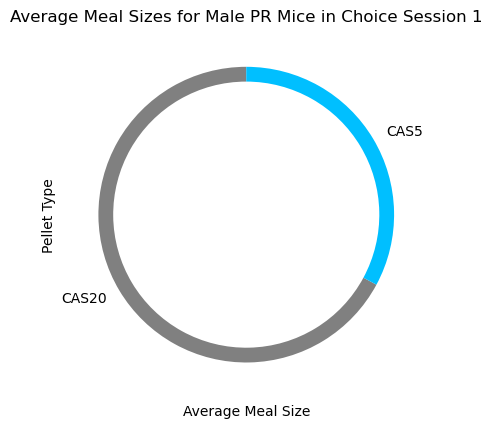

In [66]:

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Create a doughnut plot
fig, ax = plt.subplots()
ax.pie(average_meal_sizes_male_pr, labels=average_meal_sizes_male_pr.index, startangle=90, wedgeprops=dict(width=0.1), colors=[ctl_color, exp_color])

plt.xlabel('Average Meal Size')
plt.ylabel('Pellet Type')
plt.title('Average Meal Sizes for Male PR Mice in Choice Session 1')
plt.show()

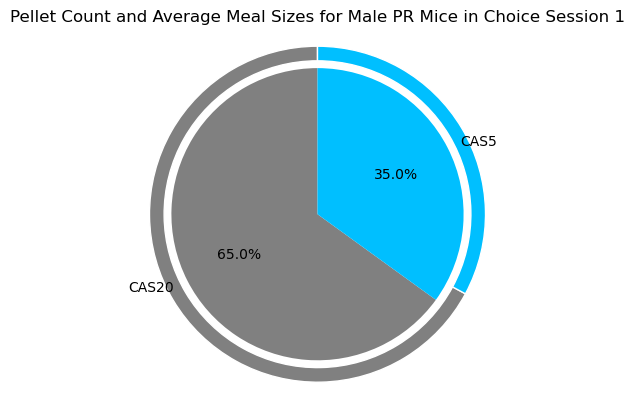

In [67]:
# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, labels=total_pellet_counts_male_pr.index, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1)
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

plt.title('Pellet Count and Average Meal Sizes for Male PR Mice in Choice Session 1')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
plt.show()

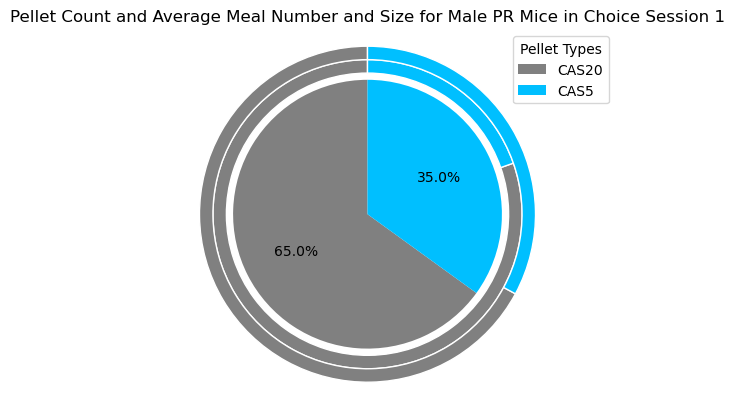

In [13]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male PR Mice in Choice Session 1')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS20', 'CAS5'], title="Pellet Types")

plt.show()

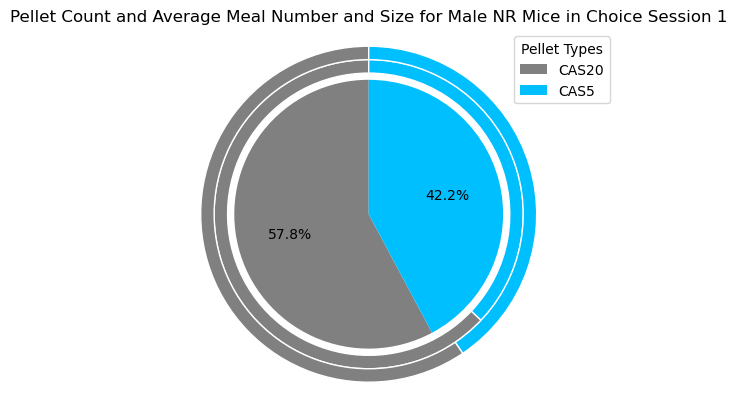

In [64]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male NR Mice in Choice Session 1')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS20', 'CAS5'], title="Pellet Types")

plt.show()

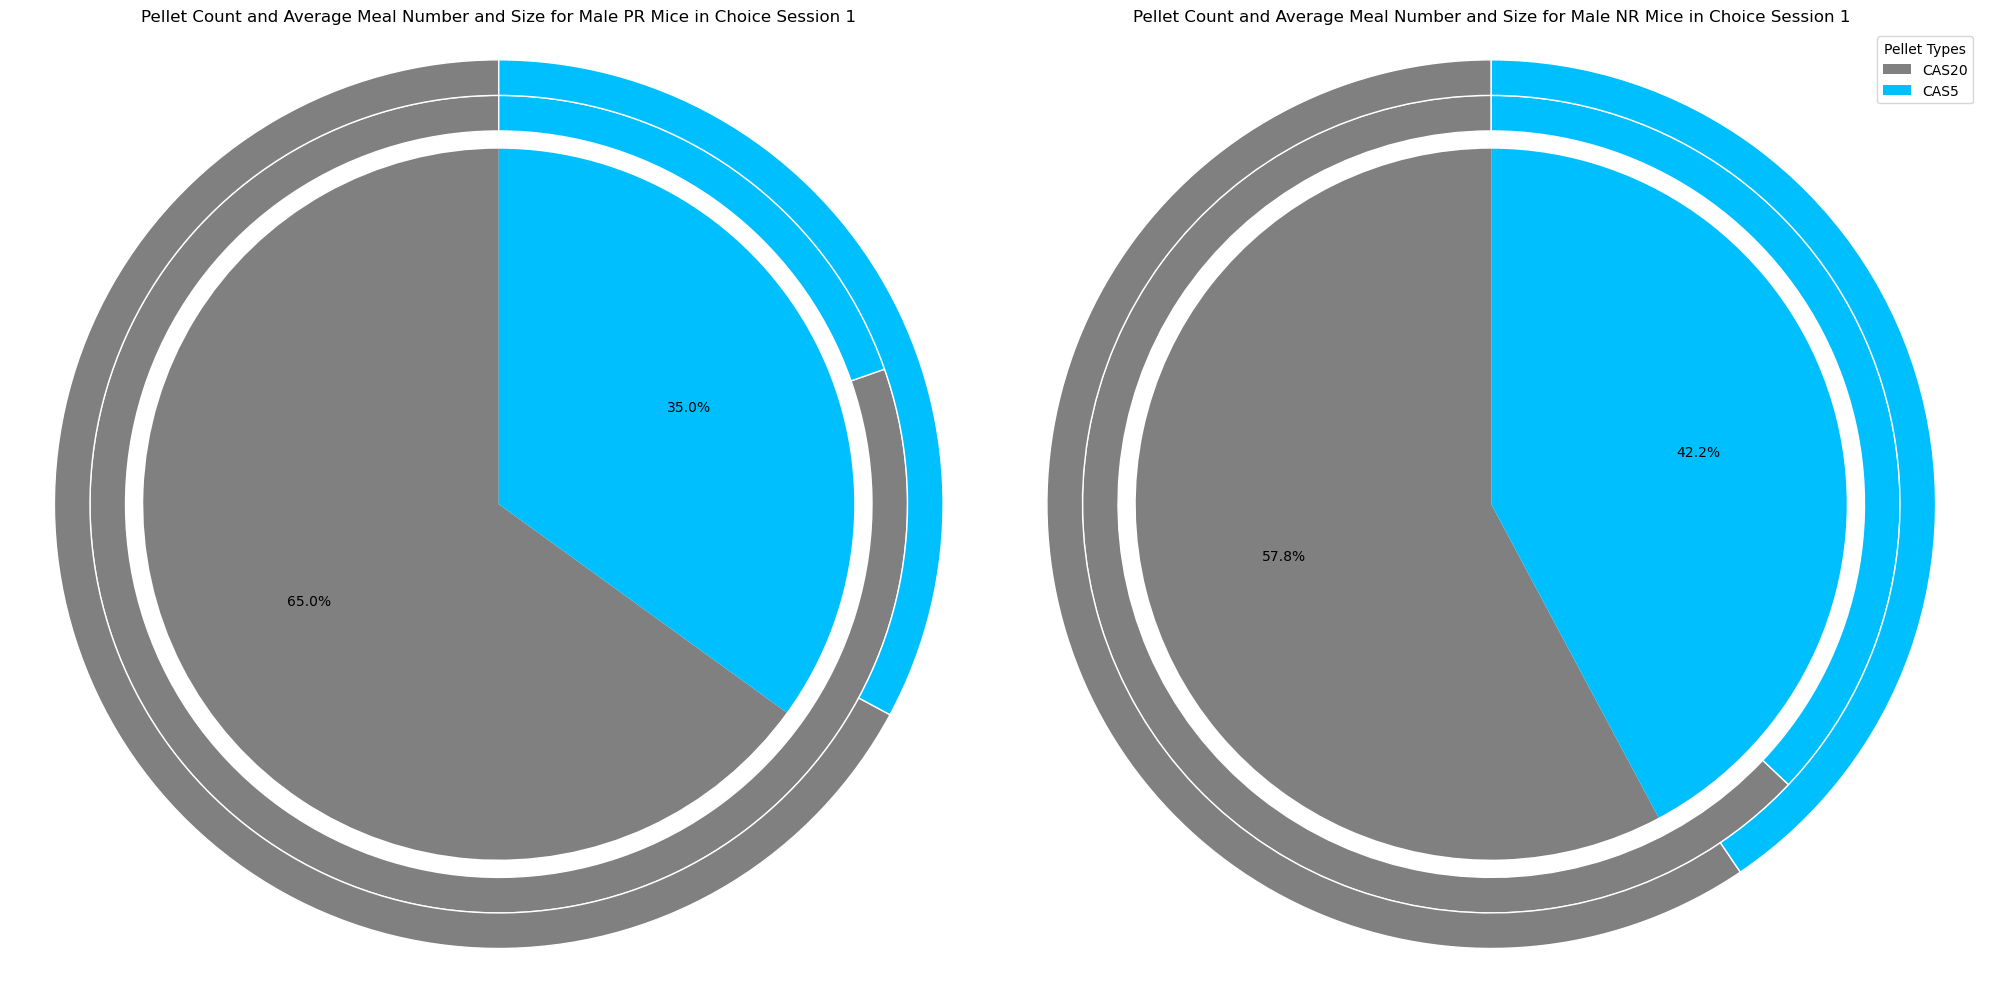

In [14]:





# Filter the data for male PR and NR mice in choice session 1 for PR diet
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()
# Calculate the average meal number for each pellet type
average_meal_number_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()
# Calculate the average meal size for each pellet type
average_meal_sizes_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Repeat for NR di
male_nr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR')]
total_pellet_counts_male_nr = male_nr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()
average_meal_number_male_nr = male_nr_pellet_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()
average_meal_sizes_male_nr = male_nr_pellet_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot for PR diet
axs[0].pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1)
axs[0].pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])
axs[0].pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
axs[0].set_title('Pellet Count and Average Meal Number and Size for Male PR Mice in Choice Session 1')
axs[0].axis('equal')


# Plot for NR diet
axs[1].pie(total_pellet_counts_male_nr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1)
axs[1].pie(average_meal_number_male_nr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])
axs[1].pie(average_meal_sizes_male_nr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
axs[1].set_title('Pellet Count and Average Meal Number and Size for Male NR Mice in Choice Session 1')
axs[1].axis('equal')
axs[1].legend(['CAS20', 'CAS5'], title="Pellet Types", loc="upper right")

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()


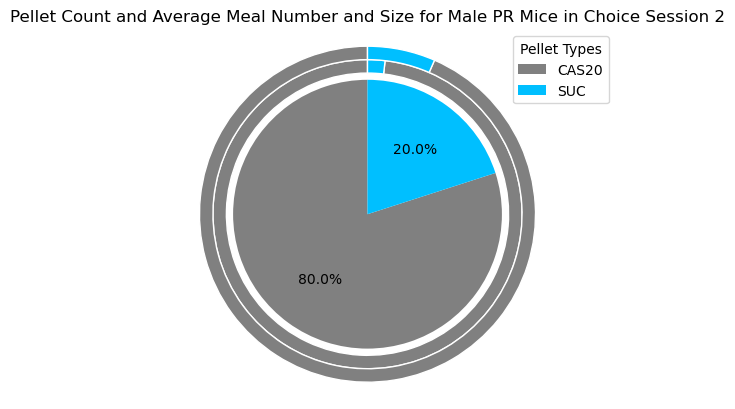

In [72]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'PR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male PR Mice in Choice Session 2')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS20', 'SUC'], title="Pellet Types")

plt.show()

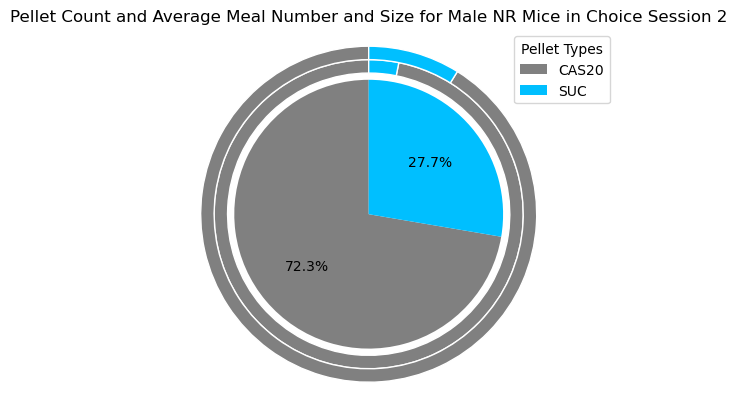

In [73]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 2) & (data['DIET'] == 'NR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male NR Mice in Choice Session 2')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS20', 'SUC'], title="Pellet Types")

plt.show()

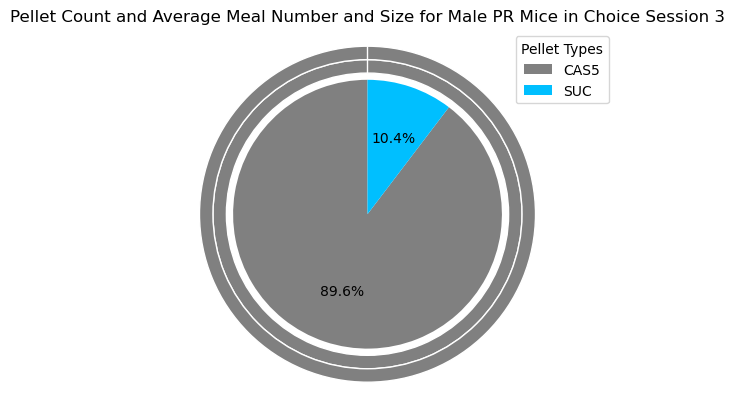

In [71]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'PR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'PR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'PR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male PR Mice in Choice Session 3')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS5', 'SUC'], title="Pellet Types")

plt.show()

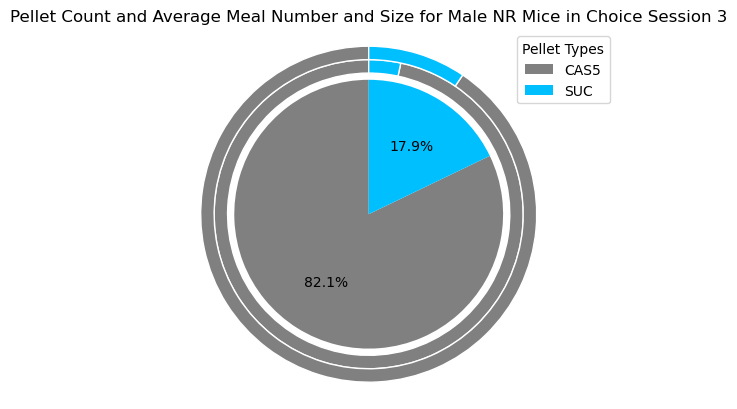

In [70]:
# Filter the data for male PR mice in choice session 1
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'NR')]

# Calculate the total pellet counts per pellet type for male PR mice in choice session 1
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()



# Filter the data for male PR mice in choice session 1
male_pr_MN_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'NR')]

# Calculate the average meal number for each pellet type for male PR mice in choice session 1
average_meal_number_male_pr = male_pr_MN_C1.groupby('PELLET_TYPE')['NUMBER_OF_MEALS'].mean()

# Filter the data for male PR mice in choice session 1
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'NR')]

# Calculate the average meal size for each pellet type for male PR mice in choice session 1
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()


# Create a combined pie and doughnut plot
fig, ax = plt.subplots()
# The pie plot
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1) #labels=total_pellet_counts_male_pr.index,
# The doughnut plot, encircling the pie plot
ax.pie(average_meal_number_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.15, colors=[ctl_color, exp_color])

ax.pie(average_meal_sizes_male_pr, startangle=90, wedgeprops=dict(width=0.1, edgecolor='w'), radius=1.25, colors=[ctl_color, exp_color])
plt.title('Pellet Count and Average Meal Number and Size for Male NR Mice in Choice Session 3')
plt.axis('equal')  # Equal aspect ratio ensures that plots are drawn as circles.
ax.legend(['CAS5', 'SUC'], title="Pellet Types")

plt.show()

# Cells below combining barh and pie plot

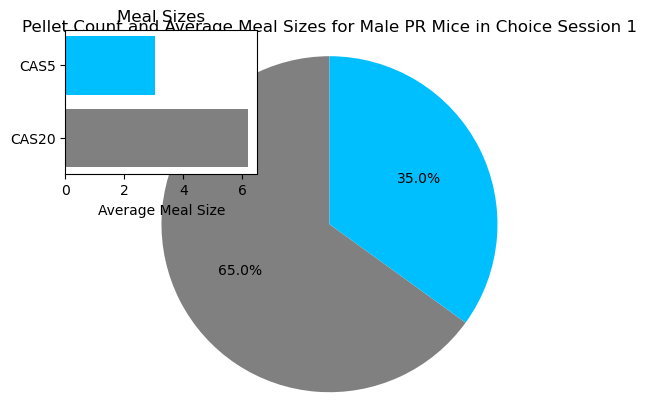

In [71]:


# Assuming 'data' is your DataFrame, 'ctl_color' is the color for control, and 'exp_color' is the color for experiment.

# Filter the data for male PR mice in choice session 1 for pellet counts
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()

# Filter the same data for meal sizes
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_meal_sizes_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_SIZE'].mean()

# Create a pie plot
fig, ax = plt.subplots()
ax.pie(total_pellet_counts_male_pr, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color], radius=1)
plt.title('Pellet Count and Average Meal Sizes for Male PR Mice in Choice Session 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create an inset axis for the barh plot
# The parameters are [left, bottom, width, height] in figure coordinates (0 to 1)
inset_axes = fig.add_axes([0.1, 0.6, 0.3, 0.3]) # Adjust this as needed to place it appropriately
inset_axes.barh(average_meal_sizes_male_pr.index, average_meal_sizes_male_pr, color=[ctl_color, exp_color])
inset_axes.set_xlabel('Average Meal Size')
inset_axes.set_title('Meal Sizes')

plt.show()


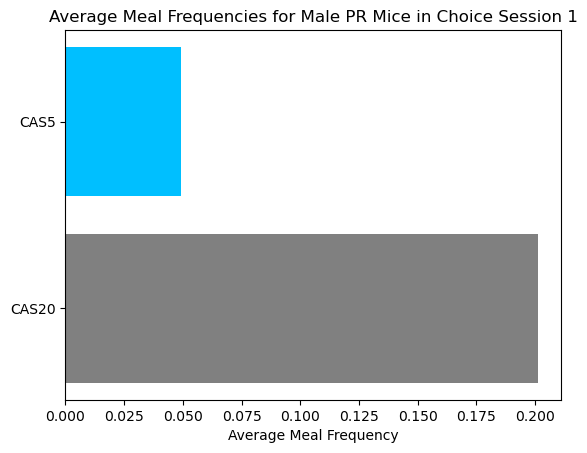

In [21]:

# Filter the data for male PR mice in choice session 1 for pellet counts
male_pr_pellet_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
total_pellet_counts_male_pr = male_pr_pellet_C1.groupby('PELLET_TYPE')['COUNT'].mean()

# Filter the same data for meal sizes
male_pr_MS_C1 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR')]
average_meal_frequency_male_pr = male_pr_MS_C1.groupby('PELLET_TYPE')['MEAL_FREQUENCY'].mean()


# Create a horizontal bar plot for the average meal frequency
fig, ax = plt.subplots()

# Extracting the labels (pellet types) and values (average meal frequencies) for the plot
pellet_types = average_meal_frequency_male_pr.index
meal_frequencies = average_meal_frequency_male_pr.values

# Creating the horizontal bar plot
ax.barh(pellet_types, meal_frequencies, color=[ctl_color, exp_color])

ax.set_xlabel('Average Meal Frequency')
ax.set_title('Average Meal Frequencies for Male PR Mice in Choice Session 1')

plt.show()


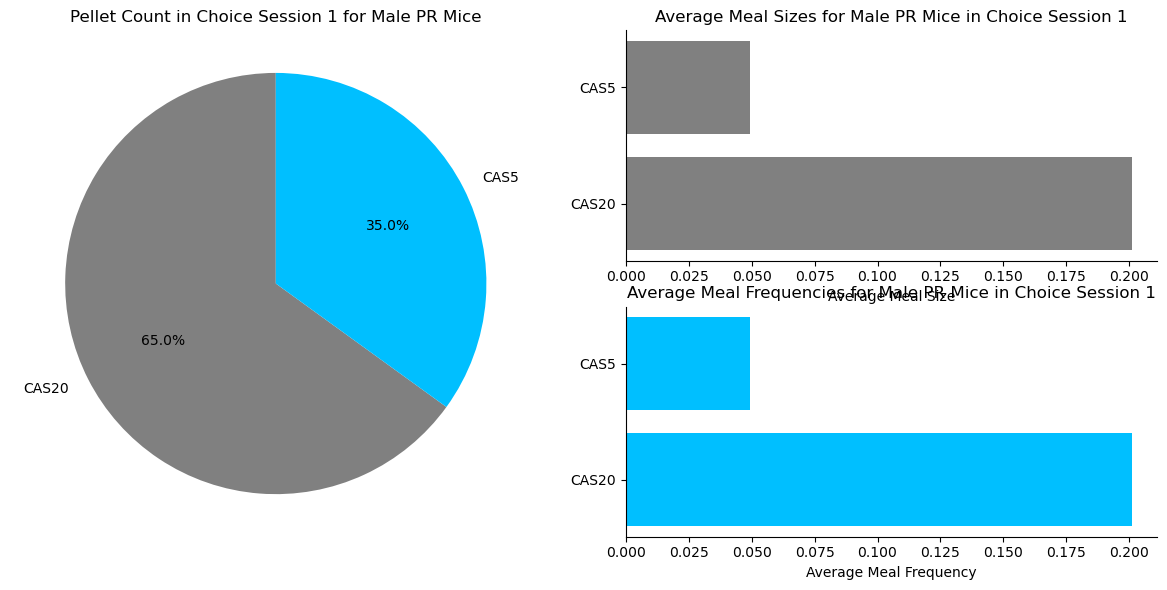

In [22]:

from matplotlib.gridspec import GridSpec

# Assuming data preparation and aggregation steps are already done and you have:
# total_pellet_counts_male_pr, average_meal_sizes_male_pr, average_meal_frequency_male_pr
# ready for plotting.

# Create figure with grid layout
fig = plt.figure(figsize=(12, 6))

# Define a grid of 1 row x 2 cols
gs = GridSpec(1, 2, figure=fig)

# Add pie plot in the left half of the figure
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(total_pellet_counts_male_pr, labels=total_pellet_counts_male_pr.index, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color])
ax1.set_title('Pellet Count in Choice Session 1 for Male PR Mice')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Define a sub-grid of 2 rows x 1 col on the right half of the figure for the barh plots
subgs = gs[0, 1].subgridspec(2, 1)

# First barh plot for meal size
ax2 = fig.add_subplot(subgs[0, 0])
ax2.barh(average_meal_sizes_male_pr.index, average_meal_sizes_male_pr, color=ctl_color)
ax2.set_title('Average Meal Sizes for Male PR Mice in Choice Session 1')
ax2.set_xlabel('Average Meal Size')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Second barh plot for meal frequency
ax3 = fig.add_subplot(subgs[1, 0])
ax3.barh(average_meal_frequency_male_pr.index, average_meal_frequency_male_pr, color=exp_color)
ax3.set_title('Average Meal Frequencies for Male PR Mice in Choice Session 1')
ax3.set_xlabel('Average Meal Frequency')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


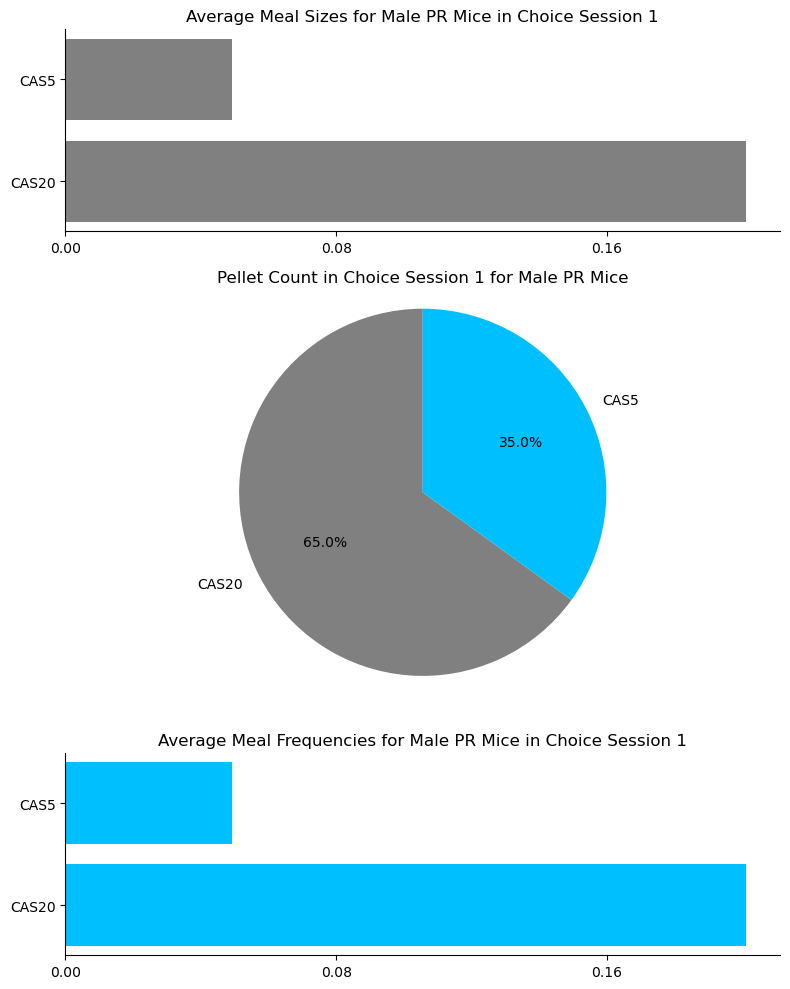

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming data preparation and aggregation steps are already done and you have:
# total_pellet_counts_male_pr, average_meal_sizes_male_pr, average_meal_frequency_male_pr
# ready for plotting.

# Create figure with a main grid layout of 3 rows x 1 column
fig = plt.figure(figsize=(8, 10))  # Adjust figure size as needed
gs = GridSpec(3, 1, figure=fig, height_ratios=[1, 2, 1])  # Allocate more space to the pie plot

# Top horizontal bar plot for meal size
ax_top = fig.add_subplot(gs[0, 0])
ax_top.barh(average_meal_sizes_male_pr.index, average_meal_sizes_male_pr, color=ctl_color)
ax_top.set_title('Average Meal Sizes for Male PR Mice in Choice Session 1')
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.xaxis.set_major_locator(plt.MaxNLocator(3))  # Limit the number of ticks to reduce clutter

# Pie plot in the middle
ax_middle = fig.add_subplot(gs[1, 0])
ax_middle.pie(total_pellet_counts_male_pr, labels=total_pellet_counts_male_pr.index, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color])
ax_middle.set_title('Pellet Count in Choice Session 1 for Male PR Mice')
ax_middle.axis('equal')  # Ensure pie is drawn as a circle

# Bottom horizontal bar plot for meal frequency
ax_bottom = fig.add_subplot(gs[2, 0])
ax_bottom.barh(average_meal_frequency_male_pr.index, average_meal_frequency_male_pr, color=exp_color)
ax_bottom.set_title('Average Meal Frequencies for Male PR Mice in Choice Session 1')
ax_bottom.spines['top'].set_visible(False)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.xaxis.set_major_locator(plt.MaxNLocator(3))  # Limit the number of ticks to reduce clutter

plt.tight_layout()
plt.show()


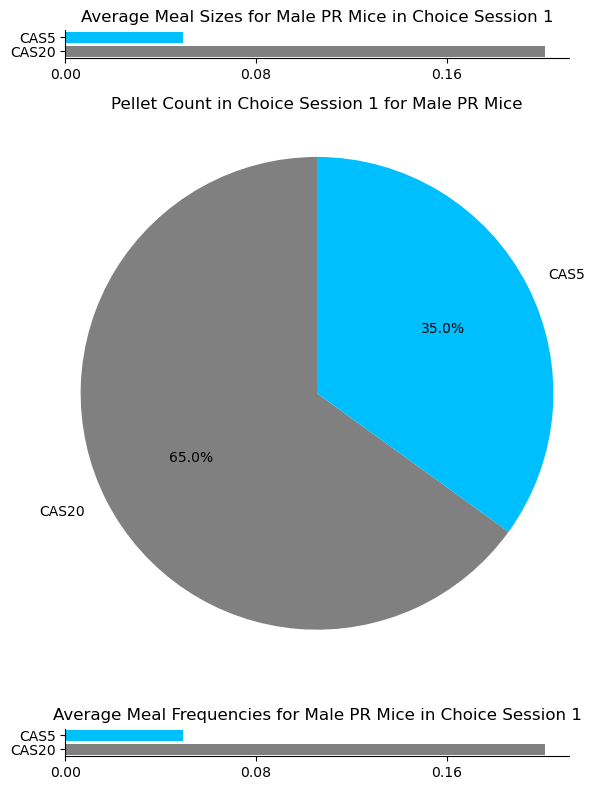

In [38]:

# Your data setup here
# average_meal_sizes_male_pr, total_pellet_counts_male_pr, average_meal_frequency_male_pr
# ctl_color, exp_color

# Adjust figure size as needed
fig = plt.figure(figsize=(6, 8))

# Adjust the height ratios to make the top bar plot smaller visually
gs = GridSpec(3, 1, figure=fig, height_ratios=[0.2, 4, 0.2])  # More space to the pie plot

# Top horizontal bar plot for meal size
ax_top = fig.add_subplot(gs[0, 0])
ax_top.barh(average_meal_sizes_male_pr.index, average_meal_sizes_male_pr, color=[ctl_color, exp_color])
ax_top.set_title('Average Meal Sizes for Male PR Mice in Choice Session 1')
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.xaxis.set_major_locator(plt.MaxNLocator(3))

# Pie plot in the middle
ax_middle = fig.add_subplot(gs[1, 0])
ax_middle.pie(total_pellet_counts_male_pr, labels=total_pellet_counts_male_pr.index, autopct='%1.1f%%', startangle=90, colors=[ctl_color, exp_color])
ax_middle.set_title('Pellet Count in Choice Session 1 for Male PR Mice')
ax_middle.axis('equal')

# Bottom horizontal bar plot for meal frequency
ax_bottom = fig.add_subplot(gs[2, 0])
ax_bottom.barh(average_meal_frequency_male_pr.index, average_meal_frequency_male_pr, color=[ctl_color, exp_color])
ax_bottom.set_title('Average Meal Frequencies for Male PR Mice in Choice Session 1')
ax_bottom.spines['top'].set_visible(False)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.xaxis.set_major_locator(plt.MaxNLocator(3))

plt.tight_layout()
plt.show()


# <font color = "gold"> Making confusion matrix </font >

C:\Users\hta031\AppData\Local\Temp\ipykernel_102856\1242902007.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_1_data.loc[mask, 'MEAL_SIZE_CLASS'] = session_1_data.loc[mask, 'MEAL_SIZE'].apply(classify, threshold=meal_size_threshold)
C:\Users\hta031\AppData\Local\Temp\ipykernel_102856\1242902007.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_1_data.loc[mask, 'MEAL_FREQUENCY_CLASS'] = session_1_data.loc[mask, 'MEAL_FREQUENCY'].apply(classify, threshold=meal_frequency_threshold)


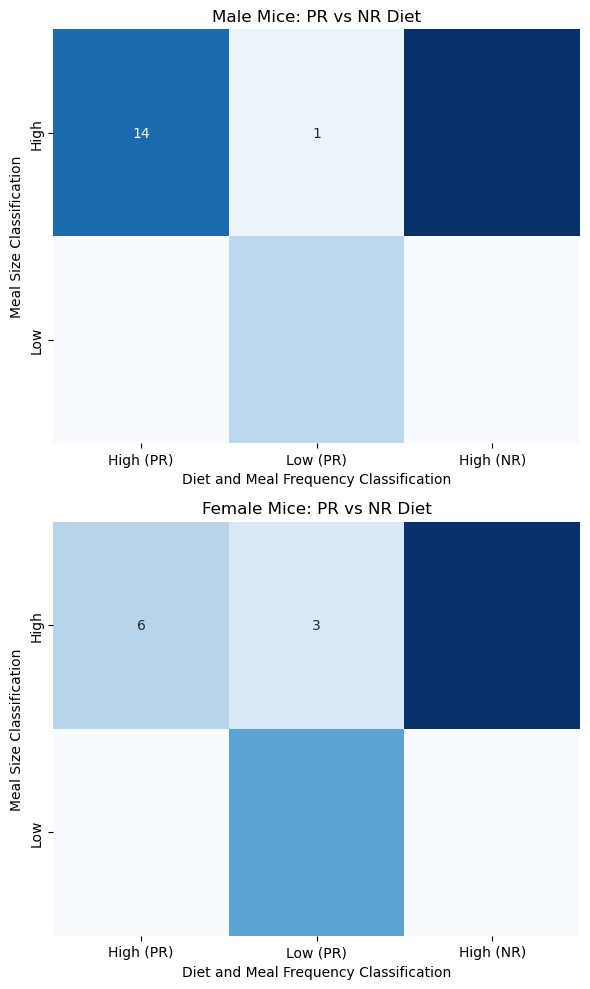

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (adjust the path as necessary)
file_path = '../results/meal_component_hour_by_hour.csv'
data = pd.read_csv(file_path)

# Filter for choice session 1
session_1_data = data[data['CHOICE_SESSION'] == 1]

# Determine thresholds for "High" and "Low" classification for meal size and meal frequency
thresholds = session_1_data.groupby('DIET').agg({
    'MEAL_SIZE': 'median',
    'MEAL_FREQUENCY': 'median'
}).reset_index()

# Function to classify as 'High' or 'Low' based on a threshold
def classify(value, threshold):
    return 'High' if value >= threshold else 'Low'

# Apply classifications
for diet in thresholds['DIET'].unique():
    diet_thresholds = thresholds[thresholds['DIET'] == diet]
    meal_size_threshold = diet_thresholds['MEAL_SIZE'].values[0]
    meal_frequency_threshold = diet_thresholds['MEAL_FREQUENCY'].values[0]
    
    # Mask to select the appropriate rows
    mask = session_1_data['DIET'] == diet
    
    # Classify
    session_1_data.loc[mask, 'MEAL_SIZE_CLASS'] = session_1_data.loc[mask, 'MEAL_SIZE'].apply(classify, threshold=meal_size_threshold)
    session_1_data.loc[mask, 'MEAL_FREQUENCY_CLASS'] = session_1_data.loc[mask, 'MEAL_FREQUENCY'].apply(classify, threshold=meal_frequency_threshold)

# Create confusion matrices for male and female mice in PR and NR diets
confusion_matrices = {}
for sex in ['M', 'F']:
    for diet in ['PR', 'NR']:
        subset = session_1_data[(session_1_data['SEX'] == sex) & (session_1_data['DIET'] == diet)]
        confusion_matrix = pd.crosstab(subset['MEAL_SIZE_CLASS'], subset['MEAL_FREQUENCY_CLASS'], margins=False)
        confusion_matrices[f"{sex}_{diet}"] = confusion_matrix

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(6, 10))  # 2 rows for Male and Female, 1 column
titles = ['Male Mice: PR vs NR Diet', 'Female Mice: PR vs NR Diet']
keys = [('M_PR', 'M_NR'), ('F_PR', 'F_NR')]

for ax, (key_pr, key_nr), title in zip(axs, keys, titles):
    cm_pr = confusion_matrices[key_pr].add_suffix(' (PR)')
    cm_nr = confusion_matrices[key_nr].add_suffix(' (NR)')
    cm_combined = pd.concat([cm_pr, cm_nr], axis=1).fillna(0).astype(int)
    sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diet and Meal Frequency Classification')
    ax.set_ylabel('Meal Size Classification')

plt.tight_layout()
plt.show()


# Cells below plotting the hourly trend of pellets intake 

In [5]:
file_path = '../results/HOURLY_PELLET.csv'
data = pd.read_csv(file_path)
data

,MOUSEID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Hour_24,Hour_25,Hour_26,Hour_27,Hour_28,Hour_29,Hour_30,Hour_31,Hour_32,Hour_33,Hour_34,Hour_35,Hour_36,Hour_37,Hour_38,Hour_39,Hour_40,Hour_41,Hour_42,Hour_43,Hour_44,Hour_45,Hour_46,Hour_47
0,FEDXDF1,F,PR,0,MIX,7.0,0.0,22.0,0.0,0.0,9.0,10.0,10.0,9.0,8.0,10.0,17.0,9.0,12.0,7.0,9.0,5.0,11.0,4.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FEDXDF1,F,PR,0,MIX,0.0,0.0,2.0,2.0,0.0,0.0,3.0,0.0,10.0,4.0,9.0,5.0,14.0,10.0,13.0,9.0,6.0,0.0,1.0,12.0,11.0,6.0,4.0,12.0,0.0,0.0,11.0,3.0,0.0,10.0,0.0,5.0,6.0,6.0,15.0,9.0,13.0,13.0,17.0,9.0,4.0,0.0,3.0,9.0,0.0,15.0,NaN
2,FEDXDF2,F,PR,0,MIX,30.0,3.0,0.0,3.0,2.0,4.0,5.0,6.0,10.0,23.0,14.0,22.0,26.0,22.0,17.0,27.0,23.0,25.0,13.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FEDXDF2,F,PR,0,MIX,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,15.0,11.0,14.0,17.0,17.0,14.0,12.0,0.0,0.0,9.0,9.0,13.0,1.0,14.0,12.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,7.0,11.0,11.0,14.0,12.0,15.0,13.0,17.0,6.0,13.0,9.0,5.0,8.0,3.0,2.0
4,FEDXDF3,F,PR,0,MIX,23.0,9.0,1.0,21.0,2.0,4.0,17.0,0.0,10.0,16.0,15.0,22.0,15.0,24.0,18.0,19.0,20.0,9.0,8.0,0.0,2.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,FEDXDF3,F,PR,0,MIX,7.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,9.0,17.0,7.0,18.0,17.0,22.0,11.0,7.0,3.0,0.0,1.0,19.0,14.0,0.0,17.0,0.0,2.0,2.0,3.0,12.0,1.0,0.0,8.0,0.0,17.0,12.0,13.0,28.0,6.0,16.0,10.0,14.0,6.0,13.0,6.0,6.0,12.0,0.0
6,FEDXDF4,F,PR,0,MIX,23.0,0.0,3.0,10.0,0.0,20.0,3.0,14.0,6.0,13.0,11.0,13.0,13.0,24.0,28.0,21.0,13.0,7.0,0.0,5.0,16.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,FEDXDF4,F,PR,0,MIX,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,14.0,12.0,12.0,13.0,17.0,18.0,14.0,14.0,7.0,0.0,1.0,15.0,15.0,0.0,13.0,2.0,0.0,0.0,5.0,0.0,4.0,0.0,10.0,6.0,7.0,8.0,6.0,7.0,11.0,13.0,11.0,5.0,17.0,6.0,0.0,12.0,5.0,0.0
8,FEDXDF5,F,PR,0,MIX,0.0,13.0,9.0,13.0,12.0,20.0,20.0,8.0,17.0,10.0,12.0,18.0,16.0,18.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,FEDXDF5,F,PR,0,MIX,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,7.0,8.0,14.0,18.0,13.0,18.0,19.0,20.0,13.0,12.0,17.0,1.0,0.0,10.0,0.0,22.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0,12.0,0.0,14.0,11.0,14.0,13.0,15.0,16.0,4.0,20.0,11.0,9.0,0.0,16.0,NaN,NaN


In [48]:
male_pr_hourly_C1_CAS20 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "CAS20")]

In [58]:
CAS20 = male_pr_hourly_C1_CAS20.iloc[:, 5:-1]


In [59]:
male_pr_hourly_C1_CAS5 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "CAS5")]

In [60]:
CAS5 = male_pr_hourly_C1_CAS5.iloc[:, 5:-1]

# np_array = df.to_numpy()

<Axes: >

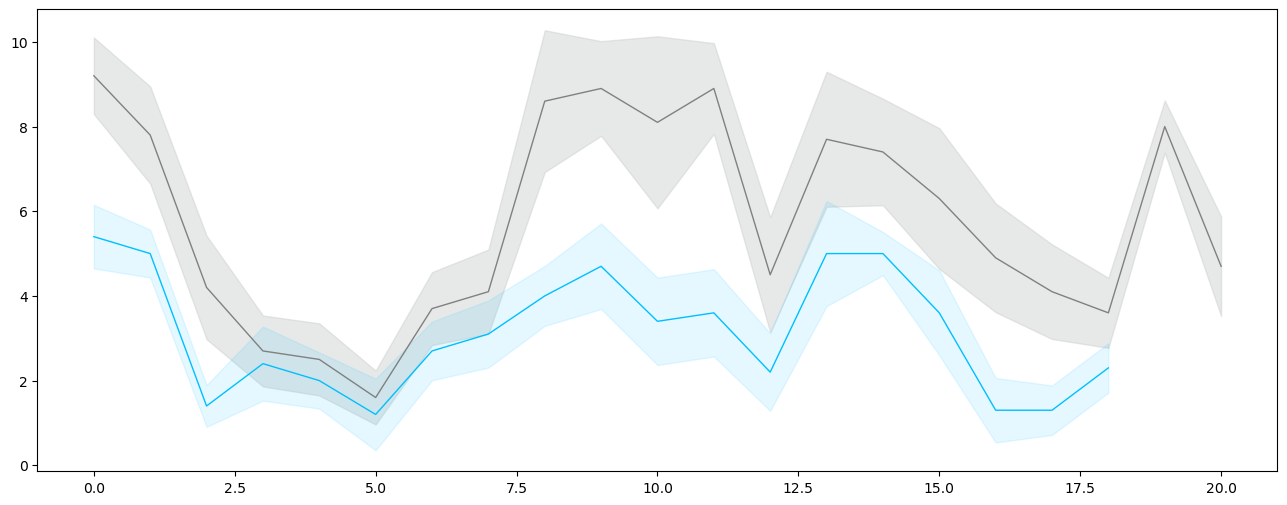

In [61]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,CAS20,linecolor=ctl_color)
tp.shadedError(ax,CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

In [10]:
male_nr_hourly_C1_CAS20 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "CAS20")]
male_nr_hourly_C1_CAS5 = data[(data['SEX'] == 'M') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "CAS5")]

In [11]:
ctl_CAS20 = male_nr_hourly_C1_CAS20.iloc[:, 5:-1]
ctl_CAS5 = male_nr_hourly_C1_CAS5.iloc[:, 5:-1]

<Axes: >

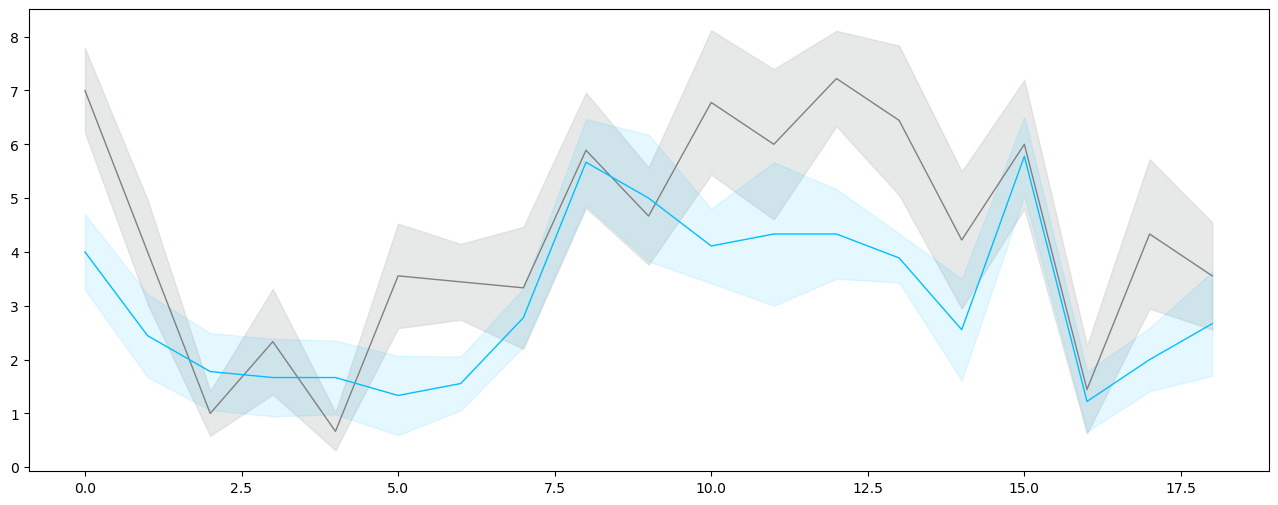

In [19]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,ctl_CAS20,linecolor=ctl_color)
tp.shadedError(ax,ctl_CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


<Axes: >

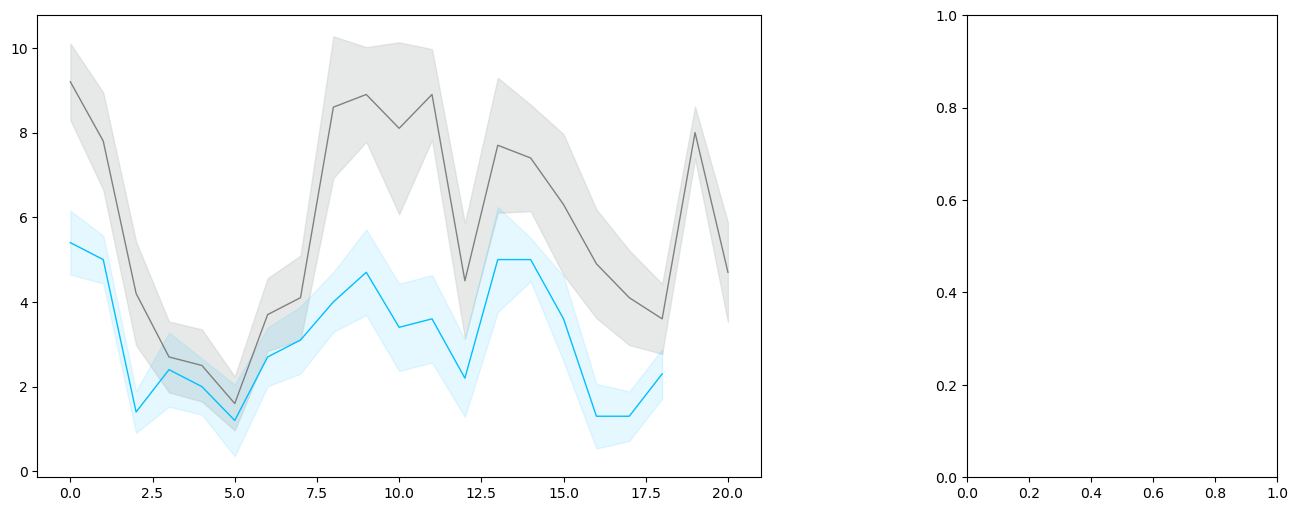

In [31]:
# f, [ax0, ax1] = plt.subplots(figsize=(16,6))
# tp.shadedError(ax,ctl_CAS20,linecolor=ctl_color)
# tp.shadedError(ax,ctl_CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


f, [ax1,ax2] = plt.subplots(figsize=(16,6), ncols=2,
                            sharey=False,
                            gridspec_kw={"width_ratios":[0.7,0.3],
                                         "right":0.9, 
                                        "wspace":0.4})
                            
tp.shadedError(ax1,CAS20,linecolor=ctl_color)
tp.shadedError(ax1,CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)


In [28]:
tp.shadedError??

Signature:
tp.shadedError(
    ax,
    yarray,
    linecolor='black',
    errorcolor='xkcd:silver',
    linewidth=1,
    linestyle='-',
    alpha=0.4,
    **kwargs,
)
Docstring:
Simple shaded error plot.

Parameters
------------
ax : Matplotlib axis object
    Axis where data will be plotted.
yarray : 2D array or List of list of floats
    Data to be plotted where rows are individual trials and columns are time bins.
linecolor : Str, optional
    Color that average (mean) will be plotted in. Default is "black".
errorcolor : Str, optional
    Color that shaded error area will be. Default is "xkcd:silver".
linewidth : Float or int, optional
    Line width for average (mean). Default is 1.
linestyle : Str, optional
    Line style for average. Default is solid ("-").
alpha : Float, optional
    Transparency of error. Should be between 0 and 1. Default is 0.4.
    
Returns
----------
ax : Matplotlib axis object
Source:   
def shadedError(ax, yarray, linecolor='black', errorcolor = 'xkcd:sil

In [65]:
female_pr_hourly_C1_CAS20 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "CAS20")]
female_pr_hourly_C1_CAS5 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "CAS5")]
exp_f_CAS20=female_pr_hourly_C1_CAS20.iloc[:, 5:-1]
exp_f_CAS5=female_pr_hourly_C1_CAS5.iloc[:, 5:-1]

<Axes: >

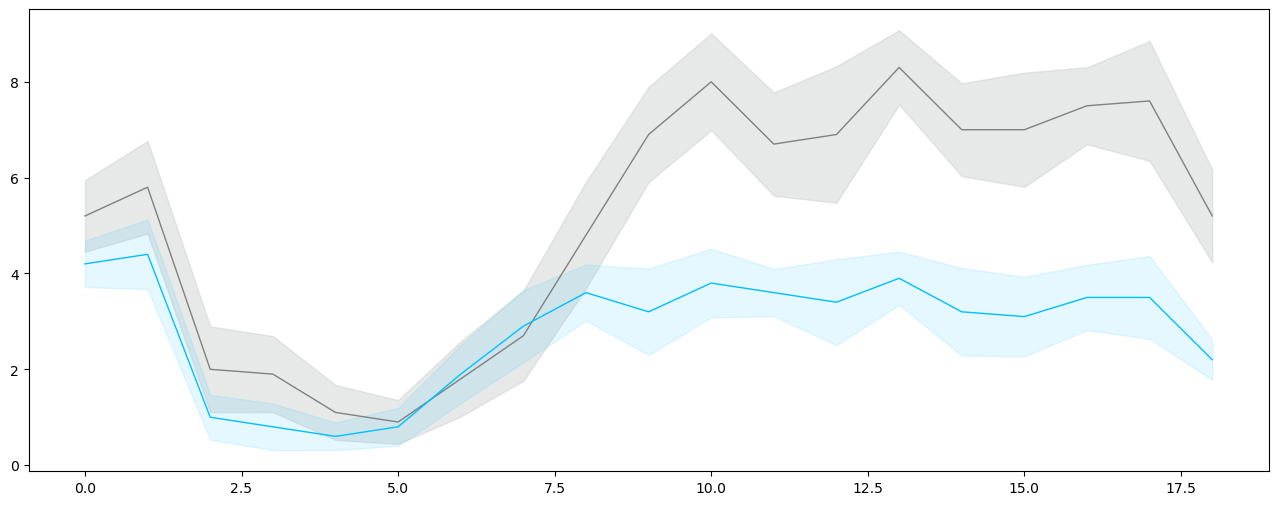

In [66]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,exp_f_CAS20,linecolor=ctl_color)
tp.shadedError(ax,exp_f_CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

In [67]:
female_nr_hourly_C1_CAS20 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "CAS20")]
female_nr_hourly_C1_CAS5 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 1) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "CAS5")]
ctl_f_CAS20=female_nr_hourly_C1_CAS20.iloc[:, 5:-1]
ctl_f_CAS5=female_nr_hourly_C1_CAS5.iloc[:, 5:-1]

<Axes: >

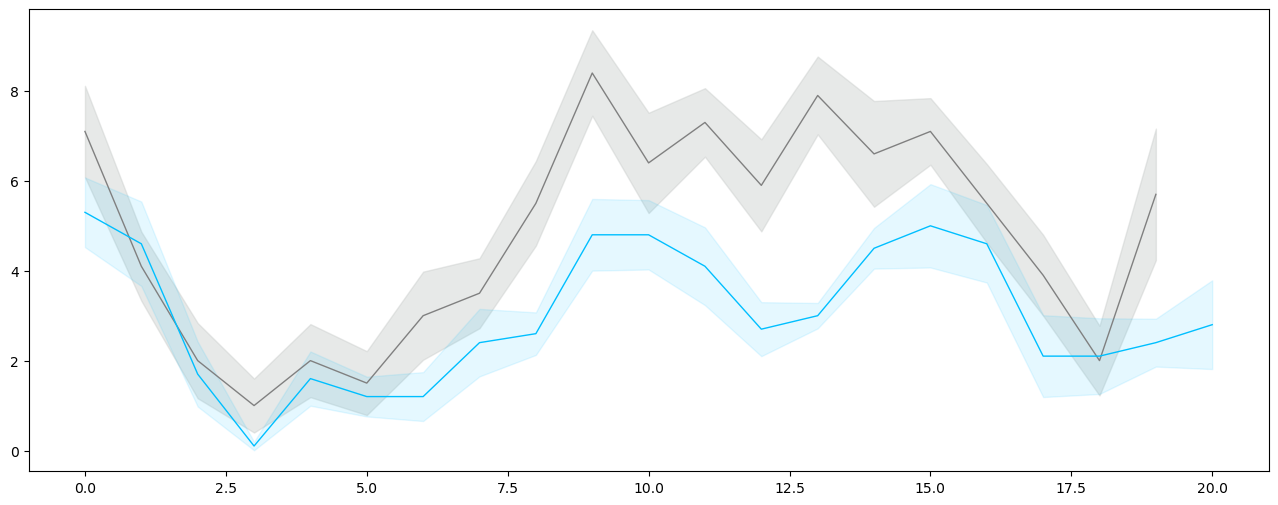

In [68]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,ctl_f_CAS20,linecolor=ctl_color)
tp.shadedError(ax,ctl_f_CAS5,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

In [71]:
female_pr_hourly_C3_CAS5 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "CAS5")]
female_pr_hourly_C3_SUC = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'PR') & (data["PELLET_TYPE"] == "SUC")]
exp_f_CAS5=female_pr_hourly_C3_CAS5.iloc[:, 5:-1]
exp_f_SUC=female_pr_hourly_C3_SUC.iloc[:, 5:-1]

<Axes: >

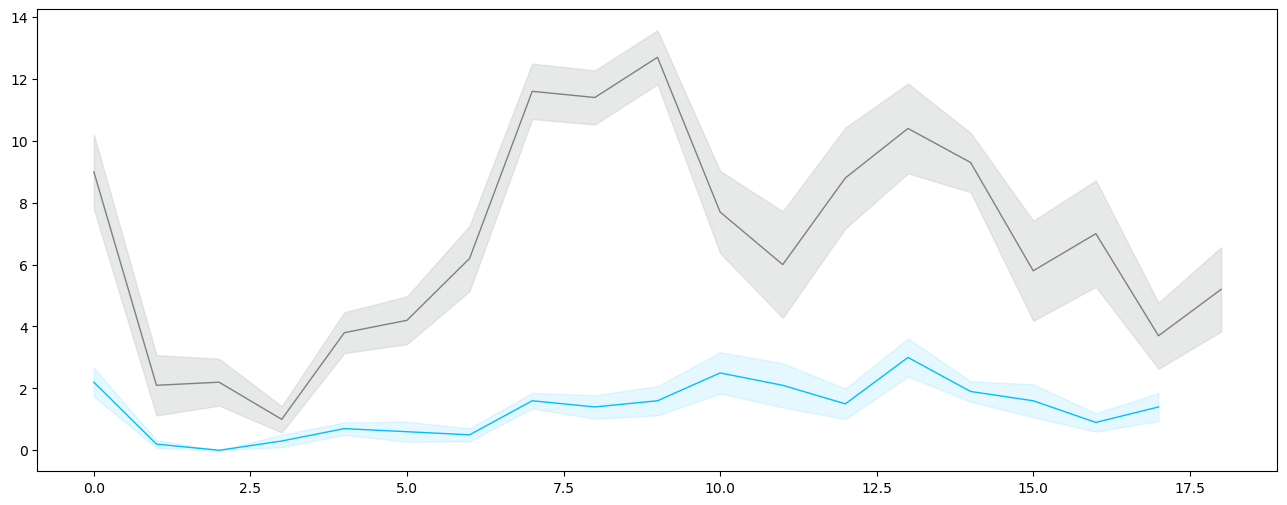

In [74]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,exp_f_CAS5,linecolor=ctl_color)
tp.shadedError(ax,exp_f_SUC,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

In [75]:
female_nr_hourly_C3_CAS5 = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "CAS5")]
female_nr_hourly_C3_SUC = data[(data['SEX'] == 'F') & (data['CHOICE_SESSION'] == 3) & (data['DIET'] == 'NR') & (data["PELLET_TYPE"] == "SUC")]
ctl_f_CAS5=female_nr_hourly_C3_CAS5.iloc[:, 5:-1]
ctl_f_SUC=female_nr_hourly_C3_SUC.iloc[:, 5:-1]

<Axes: >

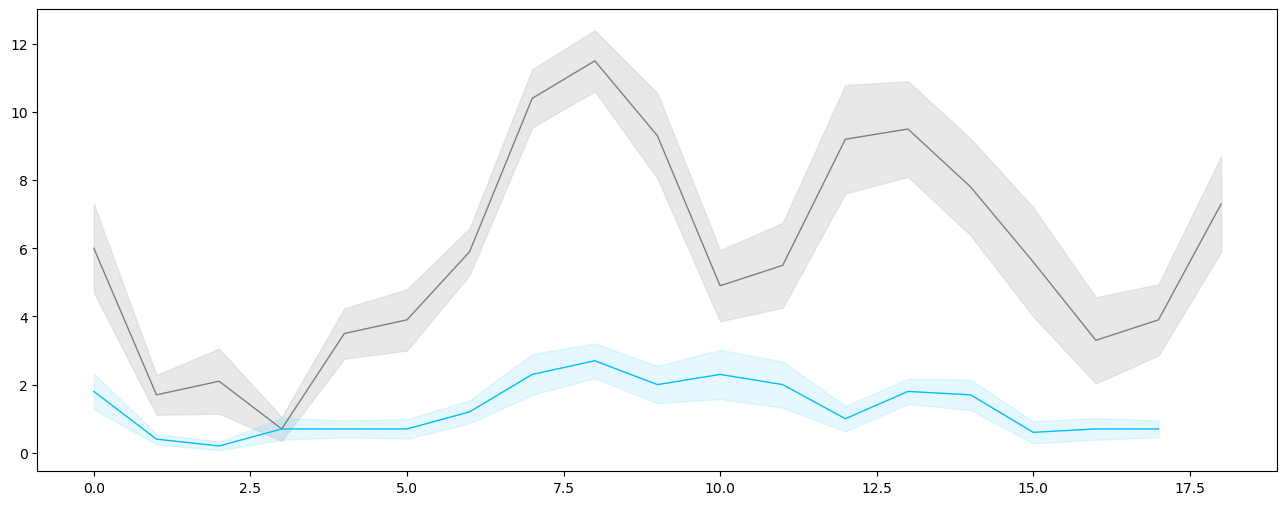

In [76]:
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,ctl_f_CAS5,linecolor=ctl_color)
tp.shadedError(ax,ctl_f_SUC,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)